## Load and Inspect Data

In [29]:

import pandas as pd

# Load the dataset
file_path = '/Users/bhanuteja/Desktop/VS code/DIC project/diabetes_prediction_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure and content
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

## Remove Duplicates

In [30]:

# Check for duplicates and remove them
initial_row_count = data.shape[0]
data.drop_duplicates(inplace=True)
duplicates_removed = initial_row_count - data.shape[0]
print(f'Duplicates Removed: {duplicates_removed}')


Duplicates Removed: 3854


## Handle 'No Info' in Smoking History

In [31]:

# Replace "No Info" in smoking_history with NaN
data['smoking_history'] = data['smoking_history'].replace("No Info", pd.NA)


Missing or incomplete values in the `smoking_history` column are replaced with `NaN` for more accurate analysis of the data.

## Rename Columns for Consistency

In [32]:

# Rename columns to have consistent names
data.columns = data.columns.str.lower().str.replace(' ', '_')


## Convert Categorical Columns to Appropriate Types

In [33]:
# Manually encode 'gender' column (Female -> 0, Male -> 1)
data['gender_encoded'] = data['gender'].map({'Female': 0, 'Male': 1})

# Manually encode 'smoking_history' column with custom mappings
smoking_mapping = {
    'never': 0,
    'former': 1,
    'current': 2,
    'NaN': -1,
    'No Info': 3  # Optionally handle 'No Info' if present
}

data['smoking_history_encoded'] = data['smoking_history'].map(smoking_mapping)

# Check the result
print(data[['gender_encoded', 'smoking_history_encoded']].head())

   gender_encoded  smoking_history_encoded
0             0.0                      0.0
1             0.0                      NaN
2             1.0                      0.0
3             0.0                      2.0
4             1.0                      2.0


In [34]:
data.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0            <NA>  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   hba1c_level  blood_glucose_level  diabetes  gender_encoded  \
0          6.6                  140         0             0.0   
1          6.6                   80         0             0.0   
2          5.7                  158         0             1.0   
3          5.0                  155         0             0.0   
4          4.8                  155         0             1.0   

   smoking_history_encoded  
0                      0.0  
1                      NaN  
2                      0.0  
3                      2.0  
4                      2.0

## Identify and Handle Outliers in BMI

In [35]:

# Handling outliers using IQR method for BMI
Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)
IQR = Q3 - Q1
# Remove outliers outside 1.5 * IQR range
data = data[(data['bmi'] >= (Q1 - 1.5 * IQR)) & (data['bmi'] <= (Q3 + 1.5 * IQR))]


The IQR (Interquartile Range) method is used to identify and remove outliers in the `bmi` column by excluding values that fall outside the 1.5 times IQR range. This helps reduce the impact of extreme values.

## Normalize the Age Column

In [36]:

# Normalize age column
data['age_normalized'] = (data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())


This normalizes the `age` column to values between 0 and 1, which helps in standardizing the scale of the data.

## Bin Age Values into Groups

In [37]:

# Bin age into categories
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 70, 100], labels=['0-30', '30-50', '50-70', '70+'])


This code categorizes the `age` column into groups (e.g., `0-30`, `30-50`, etc.), making it easier to analyze age distribution and relationships between age and diabetes.

## Standardize BMI and HbA1c Levels

In [38]:

from sklearn.preprocessing import StandardScaler

# Standardize BMI and HbA1c level columns
scaler = StandardScaler()
data[['bmi_standardized', 'hba1c_level_standardized']] = scaler.fit_transform(data[['bmi', 'hba1c_level']])


`StandardScaler` is used to standardize the `bmi` and `hba1c_level` columns, ensuring these values have a mean of 0 and a standard deviation of 1. Standardizing can improve the performance of many machine learning algorithms.

## Convert Binary Variables to Yes/No

In [39]:

# Convert hypertension and heart disease to Yes/No format
data['hypertension'] = data['hypertension'].replace({0: 'No', 1: 'Yes'}).astype('category')
data['heart_disease'] = data['heart_disease'].replace({0: 'No', 1: 'Yes'}).astype('category')


The categorical columns `gender` and `smoking_history` are encoded into numerical values. This transformation is essential for machine learning models that require numerical input.

## Create a New Feature 'At Risk'

In [40]:

# Create a new feature indicating if a person is "at-risk" based on certain conditions
data['at_risk'] = ((data['hypertension'] == 'Yes') | (data['heart_disease'] == 'Yes') | (data['bmi'] > 30)).astype(int)


# Exploratory Data Analysis (EDA)

## Univariate Analysis of Numerical Features

In [41]:

# Summary statistics of numerical features
numerical_summary = data.describe()
print(numerical_summary)


                age           bmi   hba1c_level  blood_glucose_level  \
count  90792.000000  90792.000000  90792.000000         90792.000000   
mean      41.663144     26.410518      5.520132           137.697385   
std       22.667178      5.233696      1.065622            40.342693   
min        0.080000     13.710000      3.500000            80.000000   
25%       23.000000     23.170000      4.800000           100.000000   
50%       43.000000     27.320000      5.800000           140.000000   
75%       60.000000     28.840000      6.200000           159.000000   
max       80.000000     39.550000      9.000000           300.000000   

           diabetes  gender_encoded  smoking_history_encoded  age_normalized  \
count  90792.000000    90774.000000             49490.000000    90792.000000   
mean       0.079467        0.421894                 0.523843        0.520310   
std        0.270468        0.493864                 0.774427        0.283623   
min        0.000000        0.00

## Distribution of Key Numerical Features (Histogram/Boxplot) ##

### Done By Dasarla Akshay Kumar  UBIT Name: adasarla UBIT number: 50592353 ###

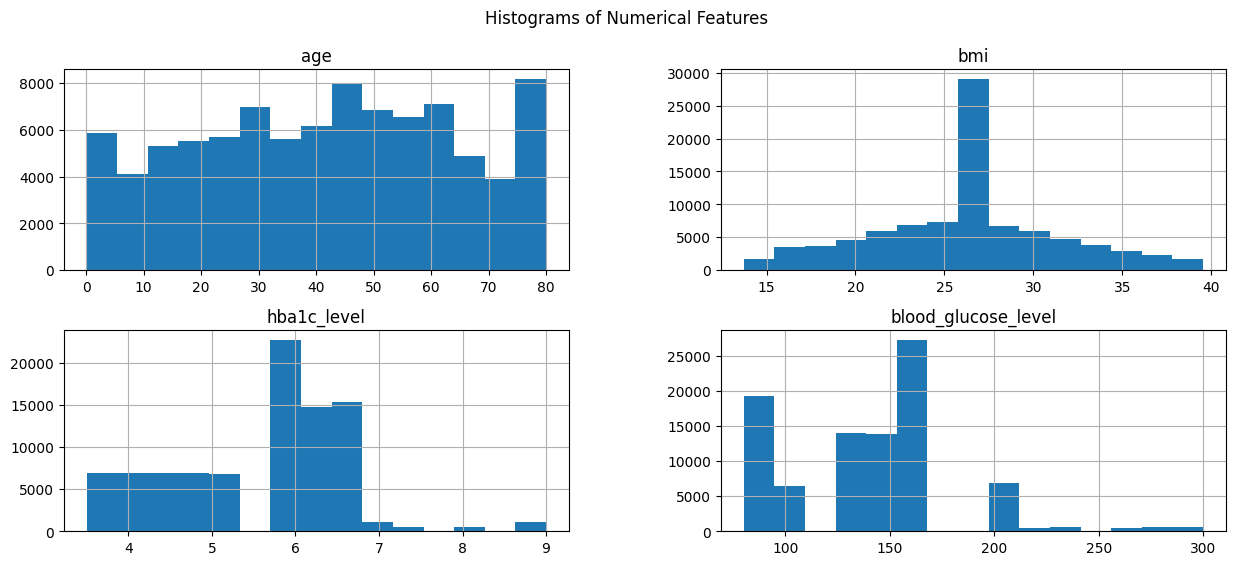

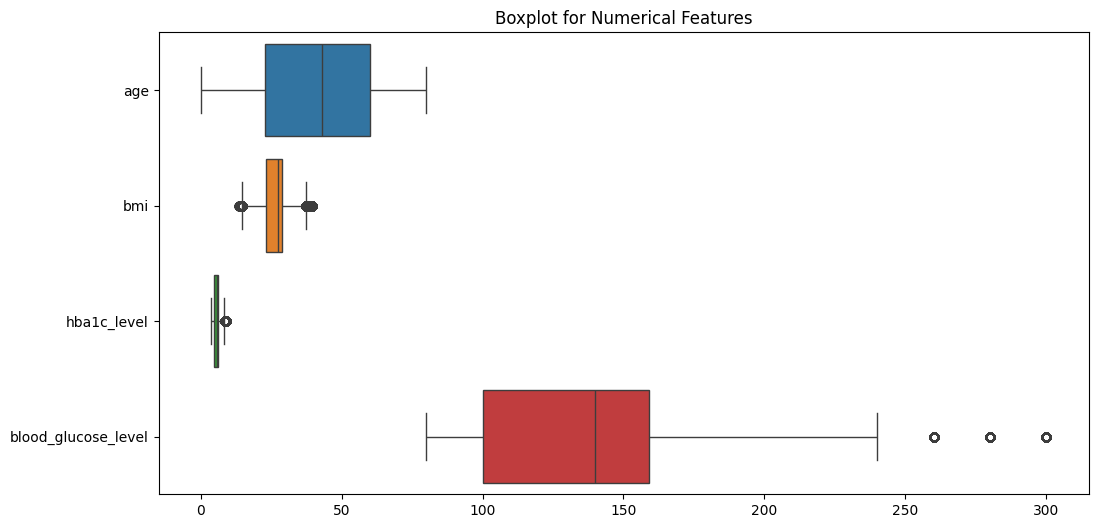

In [42]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numerical features
numerical_cols = ['age', 'bmi', 'hba1c_level', 'blood_glucose_level']
data[numerical_cols].hist(bins=15, figsize=(15, 6))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numerical_cols], orient='h')
plt.title('Boxplot for Numerical Features')
plt.show()


## Explanation:

1. **Histogram Plot:**
   - The first part of the code uses `data[numerical_cols].hist()` to generate histograms for the key numerical features: `age`, `bmi`, `hba1c_level`, and `blood_glucose_level`
   - Histograms visualize the distribution of each feature helping to identify the shape (e.g., normal distribution, skewness) and any potential anomalies in the data
   - The `bins=15` argument controls the number of bins used in the histograms, and `figsize=(15, 6)` adjusts the overall size of the plot

2. **Boxplot:**
   - The second part uses `sns.boxplot()` to generate horizontal boxplots for the same numerical columns, Boxplots are useful for detecting outliers and visualizing the spread and quartiles (Q1, Q2, Q3) of the data
   - Boxplots are oriented horizontally (using `orient='h'`), and the figure size is set to `figsize=(12, 6)` to ensure a proper display of the plot

---

## Graph Interpretation:

1. **Histograms:**
   - **Age**: The distribution of age appears roughly uniform, with more representation in the older age groups, especially around 80 years
   - **BMI**: The BMI distribution is centered around 25, suggesting most people in the dataset have a BMI close to the normal range
   - **HbA1c Level**: The histogram shows that most values cluster around 6 indicating that a large portion of the population falls into a specific HbA1c range
   - **Blood Glucose Level**: The distribution is skewed to the right, with a peak around 150, indicating that most individuals have glucose levels in this range but there are a few with significantly higher glucose levels

2. **Boxplots:**
   - **Age**: The boxplot shows a broad range of ages with a relatively uniform distribution. There are no clear outliers in age
   - **BMI**: There are a few mild outliers, but most data points are concentrated between 20 and 35, suggesting a normal distribution with a few extreme values
   - **HbA1c Level**: This boxplot reveals the presence of some outliers, as expected from the histogram
   - **Blood Glucose Level**: There are several outliers on the higher end, indicating that some individuals have exceptionally high glucose levels compared to the rest of the population


## Correlation Matrix ##

### Done By Dasarla Akshay Kumar  UBIT Name: adasarla UBIT number: 50592353 ###

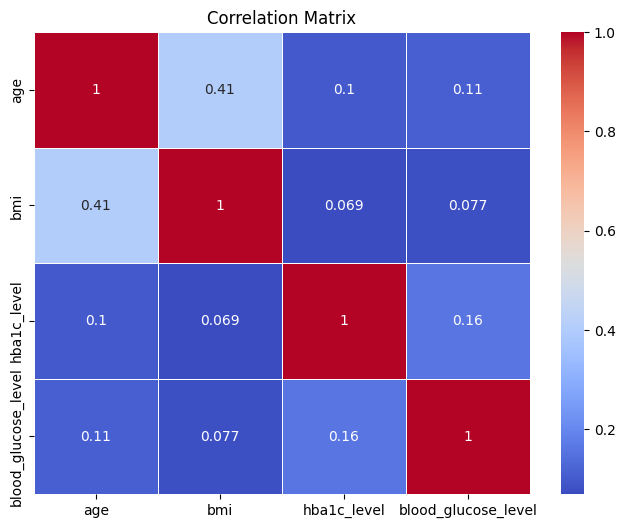

In [43]:

# Correlation matrix between numerical features
correlation_matrix = data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


## Explanation:

1. **Correlation Matrix:**
   - The `data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']].corr()` function computes the pairwise correlation coefficients between the selected numerical features (`age`, `bmi`, `hba1c_level`, and `blood_glucose_level`).
   - The correlation matrix provides a measure of how strongly pairs of variables are related to each other. Values range from -1 to 1:
     - **1**: Perfect positive correlation (as one variable increases, so does the other)
     - **0**: No correlation
     - **-1**: Perfect negative correlation (as one variable increases, the other decreases)

2. **Heatmap:**
   - A heatmap is plotted using `sns.heatmap()`, which visualizes the correlation matrix. The `annot=True` argument displays the correlation values within each cell of the heatmap
   - The `cmap='coolwarm'` parameter is used to apply a colormap, where red indicates positive correlations, blue indicates negative correlations, and white indicates little to no correlation
   - The figure size is controlled by `figsize=(8, 6)`, and `linewidths=0.5` adds spacing between the cells for better readability

---

## Graph Interpretation:

1. **Age and BMI:**
   - The correlation between `age` and `bmi` is moderate, with a value of **0.41**. This suggests that older individuals tend to have slightly higher BMI values

2. **Age and HbA1c Level:**
   - The correlation between `age` and `hba1c_level` is relatively low (**0.1**), indicating a weak positive relationship between age and HbA1c levels

3. **Age and Blood Glucose Level:**
   - The correlation between `age` and `blood_glucose_level` is also weak (**0.11**), meaning there is a slight positive association between age and blood glucose levels, but not very significant

4. **BMI and Blood Glucose Level:**
   - The correlation between `bmi` and `blood_glucose_level` is very weak (**0.077**), indicating almost no relationship between these two variables

5. **HbA1c Level and Blood Glucose Level:**
   - There is a modest correlation of **0.16** between `hba1c_level` and `blood_glucose_level`, suggesting that individuals with higher HbA1c levels tend to have slightly higher blood glucose levels

## Pairplot (Multivariate Analysis) ##

### Done By Dasarla Akshay Kumar  UBIT Name: adasarla UBIT number: 50592353 ###

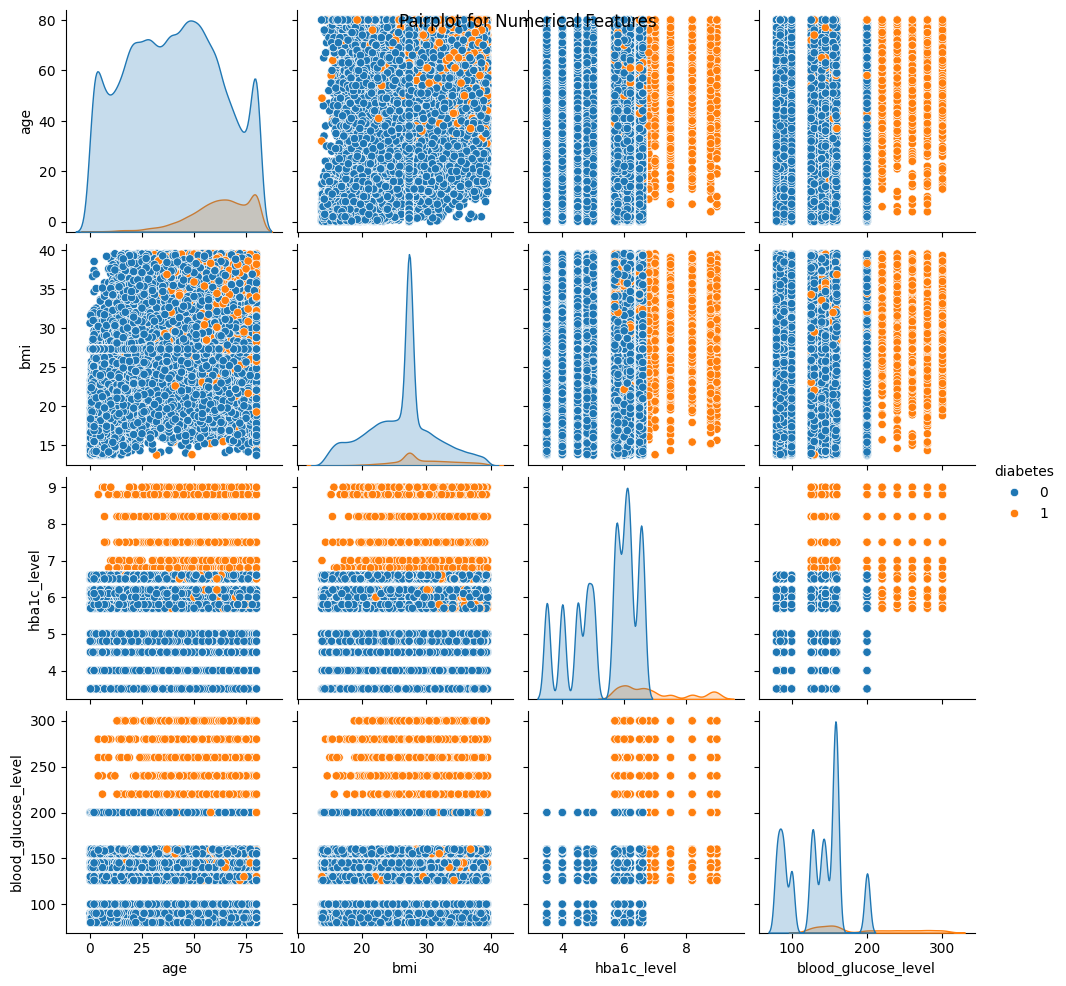

In [44]:

# Pairplot of numerical features
sns.pairplot(data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level', 'diabetes']], hue='diabetes')
plt.suptitle('Pairplot for Numerical Features')
plt.show()


## Explanation:

1. **Pairplot:**
   - The pairplot function `sns.pairplot()` is used to plot pairwise relationships between numerical features. This includes scatter plots for feature combinations and kernel density plots (KDE) along the diagonal for individual feature distributions
   - The `hue='diabetes'` argument colors the data points based on the `diabetes` column, In this case, it separates individuals with and without diabetes using different colors (e.g., blue for 0, orange for 1)
   - The `data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level', 'diabetes']]` subset includes the main features of interest (`age`, `bmi`, `hba1c_level`, `blood_glucose_level`) along with the target variable `diabetes`

---

## Graph Interpretation:

1. **Age vs BMI:**
   - The scatter plot of `age` vs `bmi` shows a relatively wide distribution. While the data is fairly spread, individuals with diabetes (orange) appear to cluster more in older age groups, suggesting a higher likelihood of diabetes with age and possibly higher BMI values

2. **Age vs HbA1c Level:**
   - The scatter plot shows a more defined band of HbA1c levels, especially around the 6-8 range. Diabetic individuals are mainly concentrated in this band, which is expected as higher HbA1c levels indicate poorer blood sugar control

3. **Age vs Blood Glucose Level:**
   - The data points for blood glucose levels show a fairly flat distribution across age. However, individuals with diabetes tend to show higher glucose levels (above 140), while non-diabetics are more concentrated below 140

4. **BMI vs HbA1c Level:**
   - This plot shows some clustering in the middle BMI range (around 25-30), with diabetic individuals tending to have higher HbA1c levels (above 6). This suggests that people with higher BMI are more likely to have elevated HbA1c levels

5. **BMI vs Blood Glucose Level:**
   - Individuals with diabetes are scattered across the BMI spectrum, but most show higher blood glucose levels (above 140). Non-diabetics tend to be in the lower glucose range, irrespective of their BMI

6. **HbA1c Level vs Blood Glucose Level:**
   - There’s a clear pattern where individuals with diabetes show a strong concentration of higher HbA1c and blood glucose levels, further confirming that HbA1c is a good indicator of diabetes status

7. **KDE Plots:**
   - The kernel density plots on the diagonal show the distribution of each feature. For example, the HbA1c level distribution for diabetic individuals is shifted to the right, indicating higher values compared to non-diabetic individuals

## Bar Chart for Categorical Features
## Done by KOSARAJU SAI SOHAN

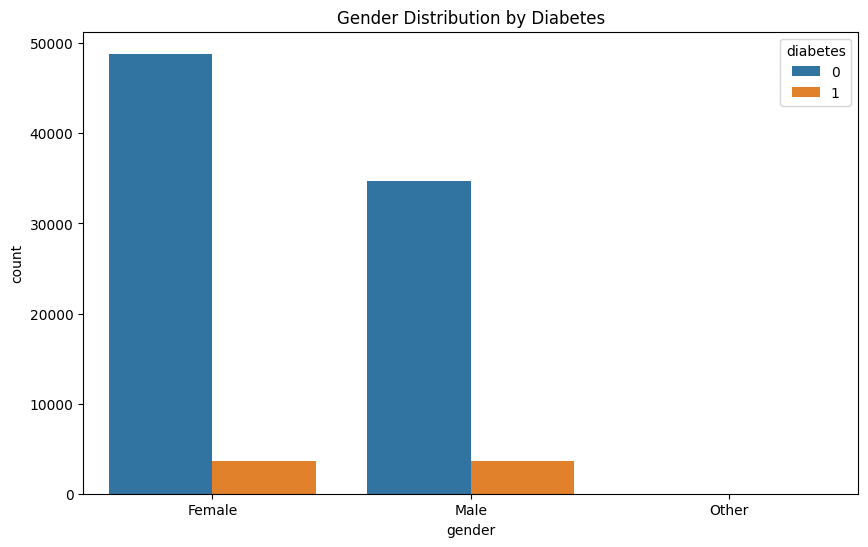

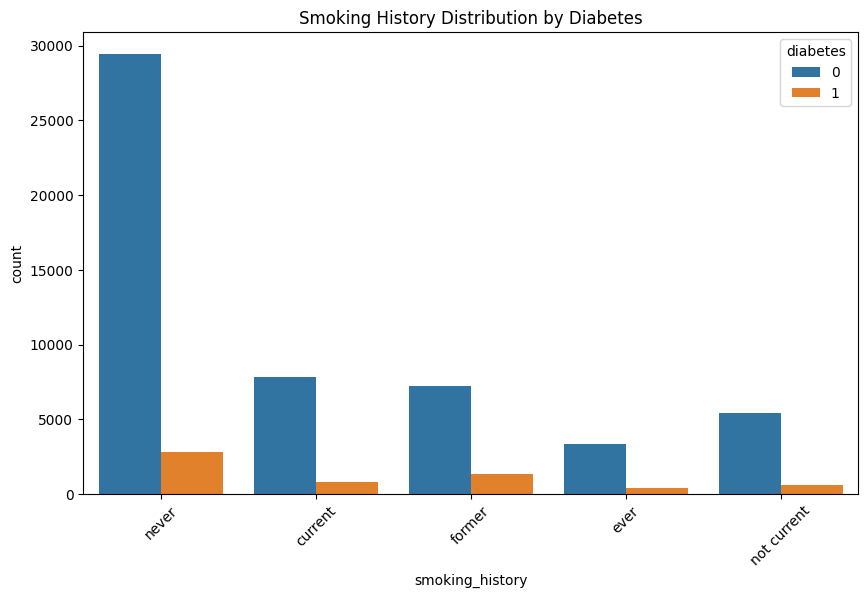

In [45]:

# Countplot for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='diabetes', data=data)
plt.title('Gender Distribution by Diabetes')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='smoking_history', hue='diabetes', data=data)
plt.title('Smoking History Distribution by Diabetes')
plt.xticks(rotation=45)
plt.show()


## Graph 1: Gender Distribution by Diabetes

### Explanation:
- The first bar chart visualizes the distribution of individuals across different genders (`Female`, `Male`, `Other`) and how diabetes prevalence (`diabetes` column) differs within each gender group.
- The bars are grouped by diabetes status:
  - **Blue**: Individuals without diabetes (diabetes = 0)
  - **Orange**: Individuals with diabetes (diabetes = 1)

### Graph Interpretation:
1. **Female**:
   - The majority of females do not have diabetes, as indicated by the large blue bar
   - A small portion of females (represented by the orange bar) have diabetes, but this number is significantly smaller compared to non-diabetics

2. **Male**:
   - There are fewer males than females in the dataset overall
   - Similar to females, the majority of males do not have diabetes (blue bar), while a smaller number of males have diabetes (orange bar)

3. **Other**:
   - The `Other` gender group has very few individuals, and the distribution shows a low count of both diabetics and non-diabetics

---

## Graph 2: Smoking History Distribution by Diabetes

### Explanation:
- The second bar chart shows the distribution of individuals by their smoking history and how it relates to their diabetes status
- The bars are grouped by diabetes status:
  - **Blue**: Individuals without diabetes (diabetes = 0)
  - **Orange**: Individuals with diabetes (diabetes = 1)

### Graph Interpretation:
1. **Never Smokers**:
   - A large portion of individuals in this category have never smoked, and most of them do not have diabetes (blue bar)
   - A smaller proportion of never smokers have diabetes (orange bar).

2. **Current Smokers**:
   - A noticeable portion of current smokers are non-diabetic (blue bar), while a smaller portion have diabetes (orange bar)

3. **Former Smokers**:
   - The distribution of former smokers follows a similar pattern, with more non-diabetics (blue) than diabetics (orange)

4. **Ever Smokers**:
   - This group is smaller compared to other smoking categories, but the same pattern holds: more non-diabetics than diabetics

5. **Not Current Smokers**:
   - This group has a relatively low number of individuals, with a majority being non-diabetic and a small number being diabetic


## KOSARAJU SAI SOHAN

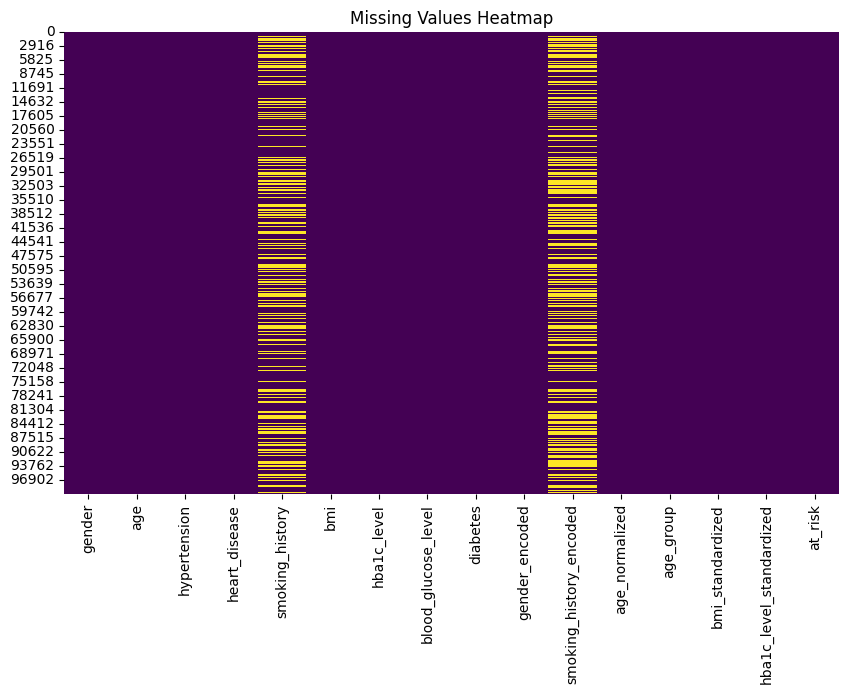

In [46]:
# Heatmap for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## Missing Values Heatmap

### Explanation:
- This heatmap visualizes missing data across different columns in the dataset
- Each row represents a record (or individual) in the dataset, and each column corresponds to a feature (e.g., `gender`, `age`, `smoking_history`)
- The heatmap highlights missing values in **yellow**, while non-missing (available) values are represented by **purple**

### Graph Interpretation:
1. **Smoking History**:
   - The `smoking_history` column shows a significant number of missing values, as indicated by the numerous yellow stripes. This feature is the most incomplete in the dataset

2. **Other Features**:
   - The remaining columns (such as `gender`, `age`, `hypertension`, `heart_disease`, `bmi`, `blood_glucose_level`, etc.) do not exhibit any missing values, as represented by the continuous purple bars. This means these features are fully populated with data

## KOSARAJU SAI SOHAN

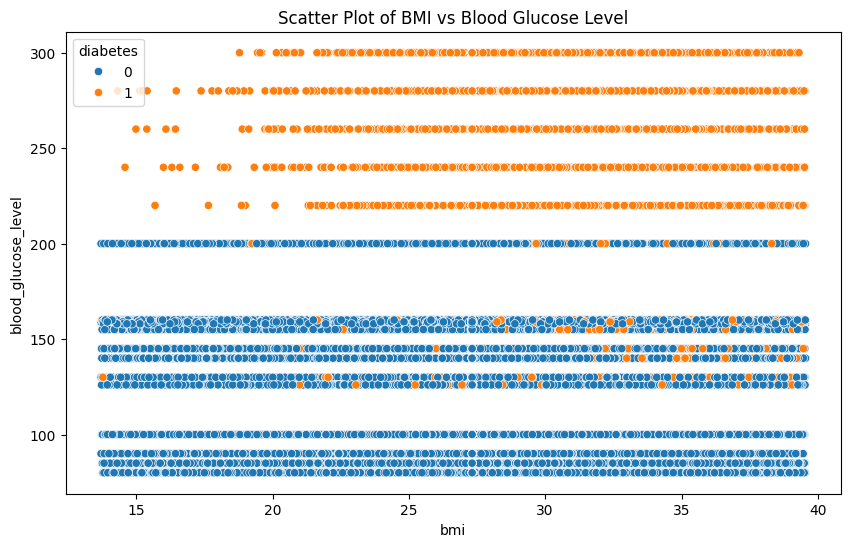

In [47]:
# Scatter plot between BMI and Blood Glucose Level
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='blood_glucose_level', hue='diabetes', data=data)
plt.title('Scatter Plot of BMI vs Blood Glucose Level')
plt.show()

## Scatter Plot: BMI vs Blood Glucose Level

### Explanation:
- The scatter plot visualizes the relationship between **BMI** (x-axis) and **blood glucose level** (y-axis) across individuals
- The data points are color-coded based on the diabetes status:
  - **Blue dots** represent individuals without diabetes (diabetes = 0)
  - **Orange dots** represent individuals with diabetes (diabetes = 1)

### Graph Interpretation:
1. **Non-Diabetics (Blue Dots)**:
   - The non-diabetic group is primarily clustered in the lower blood glucose levels (below 150 mg/dL), regardless of their BMI
   - This suggests that most non-diabetic individuals maintain a relatively stable blood glucose level, irrespective of BMI variations

2. **Diabetics (Orange Dots)**:
   - Diabetic individuals are concentrated in the higher blood glucose range (above 150 mg/dL), with many having blood glucose levels exceeding 200 mg/dL
   - Unlike the non-diabetic group, diabetics show greater variability in both BMI and blood glucose levels, with many maintaining higher blood glucose levels regardless of their BMI values

3. **BMI Range**:
   - BMI values range from around 15 to 40, and individuals with both diabetes and non-diabetes are spread across this range
   - However, BMI does not appear to be a strong determinant of blood glucose level alone, as individuals with low and high BMI exhibit both high and low blood glucose levels

## Venkata Anudeep Bandi

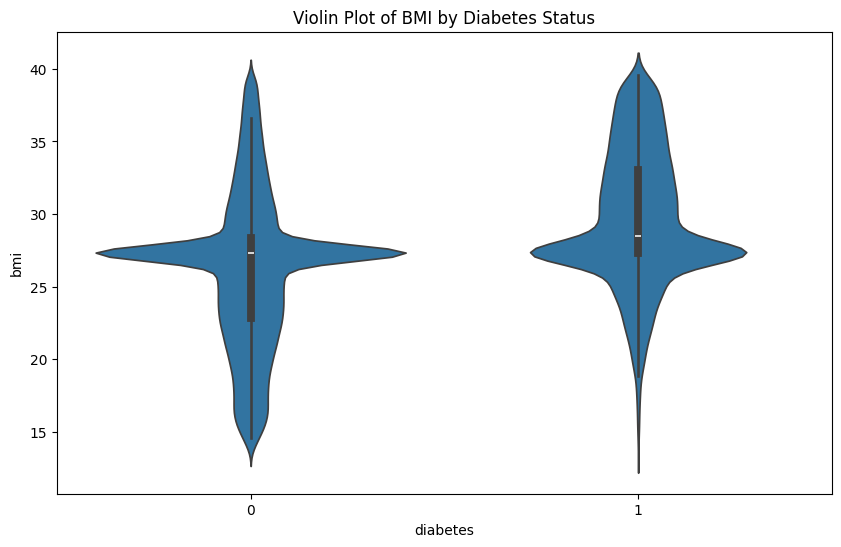

In [48]:
# Violin plot for BMI across diabetes status
plt.figure(figsize=(10, 6))
sns.violinplot(x='diabetes', y='bmi', data=data)
plt.title('Violin Plot of BMI by Diabetes Status')
plt.show()

## Violin Plot: BMI by Diabetes Status

### Explanation:
- The violin plot visualizes the distribution of **BMI** across individuals with and without diabetes (x-axis = `diabetes`, y-axis = `bmi`)
- **0** on the x-axis represents individuals without diabetes, and **1** represents individuals with diabetes
- The violin plot combines a boxplot and a density plot, showing both the summary statistics (e.g., median, quartiles) and the probability distribution of the BMI values

### Graph Interpretation:
1. **Non-Diabetics (0)**:
   - The distribution of BMI among non-diabetics is relatively wide, with most individuals having a BMI between 20 and 35
   - The peak density (widest part of the plot) occurs around a BMI of 25, indicating that most non-diabetic individuals have BMI values close to this range
   - There are fewer individuals with BMI below 20 or above 35, as seen by the tapering of the plot at the extremes

2. **Diabetics (1)**:
   - Diabetic individuals also have a wide range of BMI values, with most falling between 20 and 35
   - Similar to the non-diabetic group, the peak density for diabetics is also centered around a BMI of 25
   - The distribution of BMI for diabetics appears slightly more spread out compared to non-diabetics, suggesting more variability in BMI among individuals with diabetes

3. **Comparison**:
   - The overall shape of the BMI distribution is quite similar for both diabetics and non-diabetics, with a peak around 25 BMI and a similar spread across the BMI range
   - The spread and variability in BMI values are comparable in both groups, with no significant differences in distribution shape

## Venkata Anudeep Bandi

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_65984/1818909769.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby('age_group').agg({'blood_glucose_level': 'mean', 'bmi': 'mean'}).reset_index()


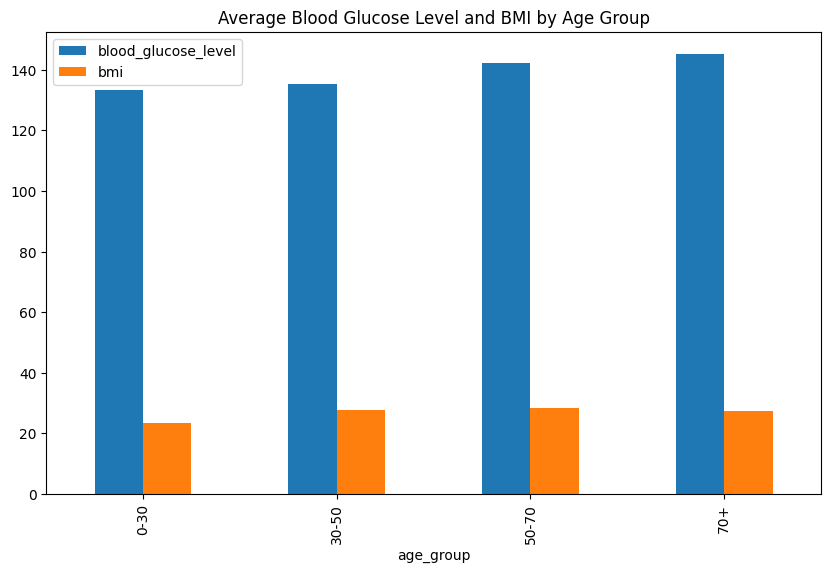

In [49]:
# Group by age group and calculate mean blood glucose level and BMI
grouped_data = data.groupby('age_group').agg({'blood_glucose_level': 'mean', 'bmi': 'mean'}).reset_index()

# Bar plot of aggregated data
grouped_data.plot(kind='bar', x='age_group', figsize=(10, 6))
plt.title('Average Blood Glucose Level and BMI by Age Group')
plt.show()

In [50]:
from scipy.stats import chi2_contingency

# Chi-square test for gender and diabetes
contingency_table = pd.crosstab(data['gender'], data['diabetes'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-square test results for Gender and Diabetes: p-value={p}')

# Chi-square test for smoking history and diabetes
contingency_table_smoking = pd.crosstab(data['smoking_history'], data['diabetes'])
chi2_smoking, p_smoking, dof_smoking, ex_smoking = chi2_contingency(contingency_table_smoking)
print(f'Chi-square test results for Smoking History and Diabetes: p-value={p_smoking}')

Chi-square test results for Gender and Diabetes: p-value=1.3730041094833239e-39
Chi-square test results for Smoking History and Diabetes: p-value=1.3828649131361586e-79


### Principal Component Analysis (PCA): ###

### Done By Bhanu Teja Veeramachanei UBIT Name: bveerama UBIT number: 50606694 ###

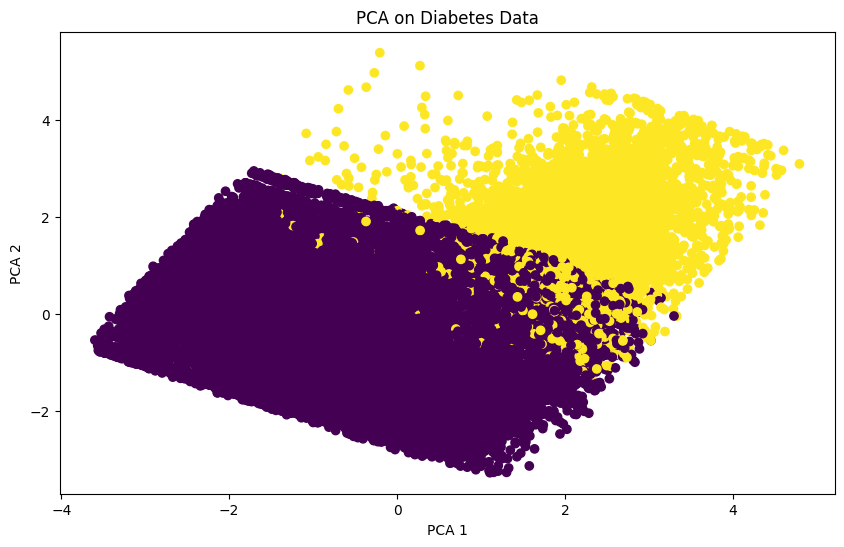

In [51]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data['diabetes'], cmap='viridis')
plt.title('PCA on Diabetes Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Bar Plot: Average Blood Glucose Level and BMI by Age Group

### Explanation:
- This bar plot compares the **average blood glucose level** (blue bars) and **average BMI** (orange bars) across different age groups
- The x-axis represents the age groups: `0-30`, `30-50`, `50-70`, and `70+`
- The y-axis represents the average values for blood glucose levels and BMI for each age group

### Graph Interpretation:
1. **Blood Glucose Level**:
   - Across all age groups, the average blood glucose level remains same, hovering around 140 mg/dL.
   - There is minimal variation in blood glucose levels between the different age groups, indicating that age does not affect average blood glucose levels

2. **BMI**:
   - The average BMI is much lower than the average blood glucose level and shows slight variation across the age groups.
   - The BMI for the `0-30` age group is slightly higher than that of the older age groups (`30-50`, `50-70`, and `70+`), but the difference is not substantial
   - Overall, BMI values remain relatively constant across all age groups, staying between 20 and 25

3. **Comparison**:
   - The blood glucose levels are significantly higher than BMI values across all age groups
   - Both BMI and blood glucose levels show limited variation between different age groups, with blood glucose levels being consistently higher in all groups

### Clustering (KMeans): ###

### Done By Bhanu Teja Veeramachanei UBIT Name: bveerama UBIT number: 50606694 ###

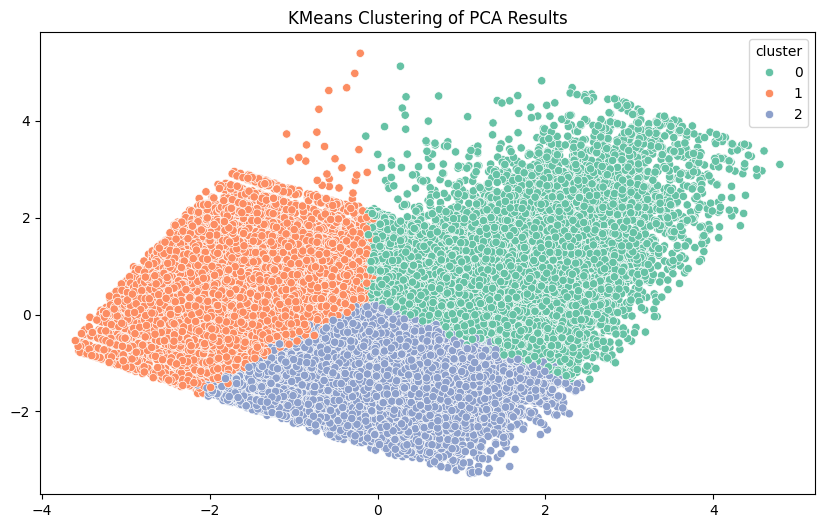

In [52]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(scaled_data)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['cluster'], palette='Set2')
plt.title('KMeans Clustering of PCA Results')
plt.show()

## PCA Plot: Diabetes Data

### Explanation:
- In this plot:
  - The x-axis represents the first principal component (**PCA 1**).
  - The y-axis represents the second principal component (**PCA 2**).
  - The colors represent different classes in the dataset: 
    - **Purple** for one class (likely non-diabetic individuals).
    - **Yellow** for the other class (likely diabetic individuals).

### Graph Interpretation:
1. **Separation Between Classes**:
   - The plot shows a clear separation between the two classes (purple and yellow), indicating that the PCA was successful in capturing the variance between the diabetic and non-diabetic individuals.
   - The purple points (likely representing non-diabetic individuals) are more concentrated towards the negative PCA 1 and PCA 2 regions, while the yellow points (diabetic individuals) spread out towards the positive PCA 1 and PCA 2 regions.

2. **Cluster of Diabetics**:
   - The yellow points (diabetics) are more dispersed in the upper-right region of the plot, suggesting a greater variability in the dataset for individuals with diabetes.

3. **Cluster of Non-Diabetics**:
   - The purple points (non-diabetics) form a tighter cluster in the lower-left corner, suggesting less variability in this group compared to diabetics.

4. **Overlap**:
   - Although there is some overlap between the two classes, the PCA was able to create a noticeable distinction between the diabetic and non-diabetic groups, which may be useful for classification purposes.

### Outlier Detection (Isolation Forest): ###

### Done By Bhanu Teja Veeramachanei UBIT Name: bveerama UBIT number: 50606694 ###

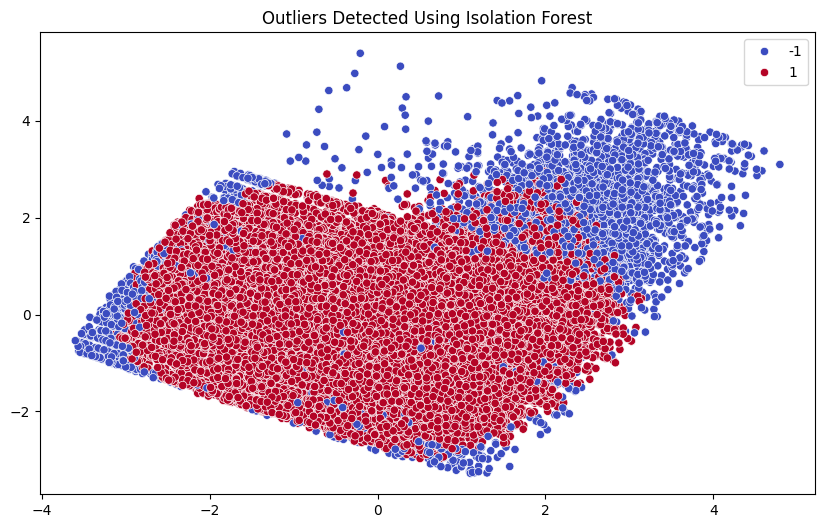

In [53]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(scaled_data)

# Scatter plot of outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=outliers, palette='coolwarm')
plt.title('Outliers Detected Using Isolation Forest')
plt.show()

## Outliers Detected Using Isolation Forest

### Explanation:
- In the plot:
  - **Blue points** (label `-1`) represent data points classified as **outliers**
  - **Red points** (label `1`) represent data points classified as **normal observations**
  - The x-axis represents the first principal component (**PCA 1**) and the y-axis represents the second principal component (**PCA 2**), as in a PCA plot used to reduce the dimensionality of the dataset

### Graph Interpretation:
1. **Outliers (Blue Points)**:
   - The blue points are scattered throughout the dataset but tend to be more concentrated towards the edges of the distribution
   - Some blue points also appear within the denser clusters (red regions), indicating that these points are slightly different from the majority of observations in that area

2. **Normal Observations (Red Points)**:
   - The majority of data points are classified as normal observations (red points), forming a dense cluster in the center of the plot
   - These points represent the main structure of the dataset, with normal values grouped together in the middle of the PCA space

### Feature Selection (SelectKBest): ###

### Done By Bhanu Teja Veeramachanei UBIT Name: bveerama UBIT number: 50606694 ###

In [54]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection using SelectKBest
X = data[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']]
y = data['diabetes']
best_features = SelectKBest(score_func=f_classif, k=2).fit(X, y)

# Get scores for features
scores = best_features.scores_
print(f'Feature scores: {scores}')

Feature scores: [ 6646.65299628  3016.68483419 16493.23831913 18534.76835345]


### Regression Analysis (Logistic Regression): ###

### Done By Bhanu Teja Veeramachanei UBIT Name: bveerama UBIT number: 50606694 ###

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Logistic regression on selected features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     25059
           1       0.88      0.61      0.72      2179

    accuracy                           0.96     27238
   macro avg       0.92      0.80      0.85     27238
weighted avg       0.96      0.96      0.96     27238



# **Bhanu Teja Veeramachaneni**

**UBIT Name**: `bveerama`

**UBIT Number**: `50606694`

# Hypothesis 1 #

## How do various combinations of clinical indicators (e.g., BMI, hypertension, heart disease, HbA1c level) interact to influence the risk of diabetes?

### Significance:
Because clinical markers including body mass index (BMI), hypertension, and heart disease are well-established indications of diabetes risk, this question is crucial. Nonetheless, a more complete picture of diabetes risk can be obtained by comprehending how these variables interact with one another in combination. It might show if the chance of getting diabetes rises exponentially with the number of risk factors or whether some risk factors are more important than others.


### Objective:
The purpose is to evaluate how different combinations of clinical markers affect the likelihood of diabetes. Does someone who has high blood pressure and a high BMI, for instance, have a higher chance of developing diabetes than someone who only has one of these conditions? This approach assists in creating risk profiles and could be used to adapt preventative health strategies more effectively. More individualized healthcare suggestions may also be supported by insights into the relationships between various parameters.


In [57]:
import pandas as pd

bhanu_df = pd.read_csv("/Users/bhanuteja/Desktop/VS code/DIC project/diabetes_prediction_dataset.csv")

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 90792 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   gender                    90792 non-null  object  
 1   age                       90792 non-null  float64 
 2   hypertension              90792 non-null  category
 3   heart_disease             90792 non-null  category
 4   smoking_history           59212 non-null  object  
 5   bmi                       90792 non-null  float64 
 6   hba1c_level               90792 non-null  float64 
 7   blood_glucose_level       90792 non-null  int64   
 8   diabetes                  90792 non-null  int64   
 9   gender_encoded            90774 non-null  float64 
 10  smoking_history_encoded   49490 non-null  float64 
 11  age_normalized            90792 non-null  float64 
 12  age_group                 90792 non-null  category
 13  bmi_standardized          90792 non-null  float64 


gender   age hypertension heart_disease smoking_history    bmi  \
0  Female  80.0           No           Yes           never  25.19   
1  Female  54.0           No            No            <NA>  27.32   
2    Male  28.0           No            No           never  27.32   
3  Female  36.0           No            No         current  23.45   
4    Male  76.0          Yes           Yes         current  20.14   

   hba1c_level  blood_glucose_level  diabetes  gender_encoded  \
0          6.6                  140         0             0.0   
1          6.6                   80         0             0.0   
2          5.7                  158         0             1.0   
3          5.0                  155         0             0.0   
4          4.8                  155         0             1.0   

   smoking_history_encoded  age_normalized age_group  bmi_standardized  \
0                      0.0        1.000000       70+         -0.233205   
1                      NaN        0.674675     50-70          0.173775   
2                      0.0        0.349349      0-30          0.173775   
3                      2.0        0.449449     30-50         -0.565668   
4                      2.0        0.949950       70+         -1.198112   

   hba1c_level_standardized  at_risk  cluster  
0                  1.013374        1        0  
1                  1.013374        0        2  
2                  0.168793        0        0  
3                 -0.488104        0        1  
4                 -0.675789        1        2

In [ ]:
# Replace 'No Info' with NaN in the 'smoking_history' column
bhanu_df['smoking_history'] = bhanu_df['smoking_history'].replace('No Info', pd.NA)

# Remove duplicate rows (if any)
data_cleaned = bhanu_df.drop_duplicates()

# Verify data after cleaning
print(f"Original shape: {bhanu_df.shape}")
print(f"Cleaned shape: {data_cleaned.shape}")

Original shape: (100000, 9)
Cleaned shape: (96146, 9)


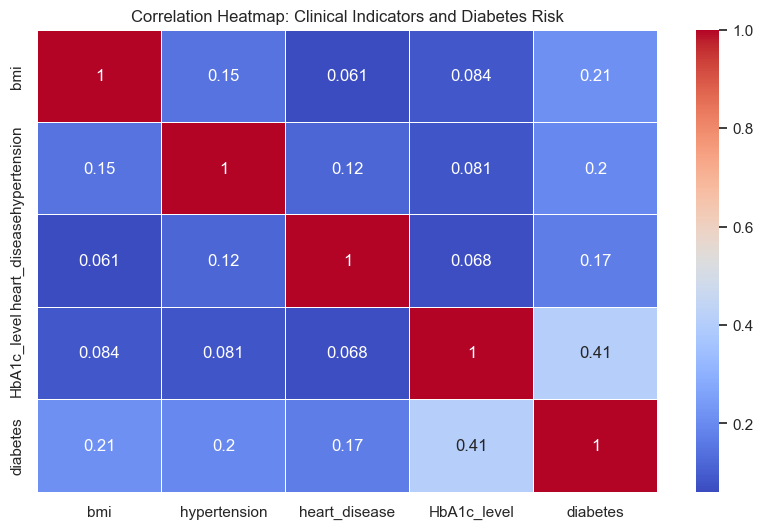

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better readability
sns.set(style="whitegrid")

# Correlation heatmap of clinical indicators and diabetes
plt.figure(figsize=(10, 6))
sns.heatmap(data_cleaned[['bmi', 'hypertension', 'heart_disease', 'HbA1c_level', 'diabetes']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Clinical Indicators and Diabetes Risk")
plt.show()

## Correlation Heatmap: Clinical Indicators and Diabetes Risk

This heatmap illustrates the correlation between clinical indicators (BMI, hypertension, heart disease, HbA1c level) and diabetes:

- **BMI** has the strongest positive correlation with diabetes (0.21), followed by hypertension (0.20) and heart disease (0.17).
- **HbA1c level** shows the highest correlation with diabetes at 0.41, indicating its importance as a clinical indicator for diabetes risk.
- The interactions between other clinical factors like hypertension and heart disease show relatively weak correlations, indicating they might not interact strongly to predict diabetes on their own but are important factors.

# Hypothesis 2 #

## How do lifestyle factors (e.g., smoking history, physical inactivity) affect the onset and progression of diabetes across different demographic groups (age, gender)?

### Significance:
Lifestyle decisions like smoking and not exercising are proven to have a big influence on one's health. Studying the ways in which these variables influence the occurrence of diabetes in different populations can yield significant findings about preventive medicine. For instance, younger groups could have distinct risk profiles compared to older ones, and recognizing this variance is crucial to devising age-specific health interventions. Similarly, gender-sensitive health strategies may be influenced by variations in how lifestyle decisions affect diabetes.


### Objective:
This question intends to study if lifestyle variables effect the onset and course of diabetes differently in varied demographic groups. In this way, the study can assist create targeted interventions by generating hypotheses about which demographic groups are more susceptible to diabetes caused by lifestyle choices. For instance, it may suggest that early treatments are essential for some populations to avoid the onset of diabetes if smoking and physical inactivity have a greater negative impact on younger guys than older females.


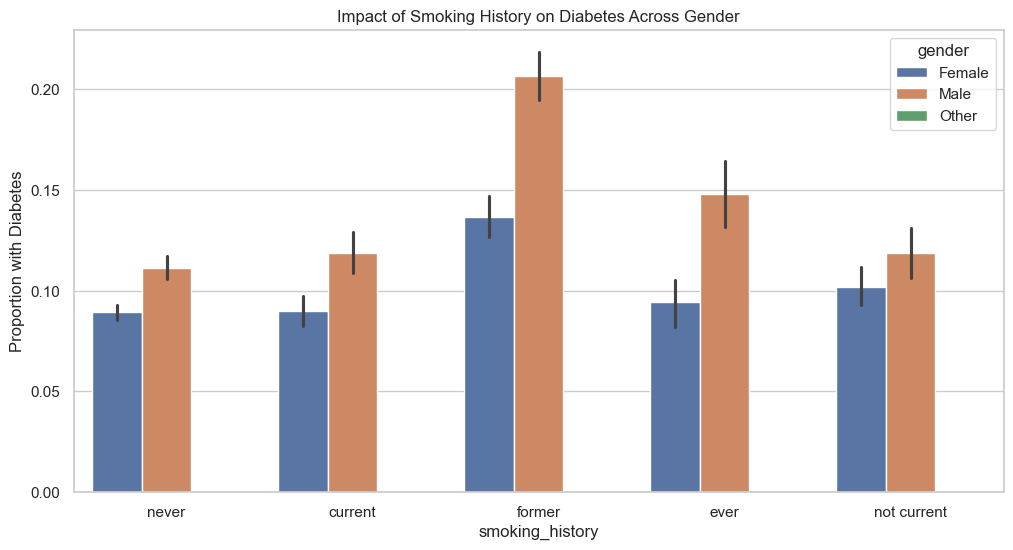

In [ ]:
# Bar plot for smoking history vs diabetes across gender
plt.figure(figsize=(12, 6))
sns.barplot(x='smoking_history', y='diabetes', hue='gender', data=data_cleaned, estimator=lambda x: sum(x)/len(x))
plt.title("Impact of Smoking History on Diabetes Across Gender")
plt.ylabel("Proportion with Diabetes")
plt.show()

## Impact of Smoking History on Diabetes Across Gender

This bar plot shows how smoking history affects diabetes risk across gender:

- **Former smokers** in both males and females show the highest proportion of diabetes, with males having a slightly higher diabetes rate in this group.
- **Current smokers** and those who have “never smoked” show similar, moderate diabetes rates across genders.
- Overall, **males** consistently show a higher proportion of diabetes across all smoking history categories compared to females.

## Dasarla Akshay Kumar , 50592353

### Hypothesis - 1 : Does an individual's BMI correlate with their likelihood of developing diabetes?

Body Mass Index (BMI) is an important health metric, it is recognized as an indicator of body fat and a strong predictor of metabolic conditions. Since obesity and high BMI values are often related to an increased risk of developing chronic conditions such as diabetes, this hypothesis aims to examine whether a higher BMI is corelated with a higher prevalence of diabetes.

One of the most common chronic diseases in the world is diabetes, and early detection and prevention depend on knowing risk factors like BMI. If a substantial correlation is discovered between BMI and diabetes, this would assist medical practitioners in creating more specialized interventions and preventative plans for those with higher BMIs. Verifying this association may further support the use of BMI as a critical component in predictive models for diabetes detection, increasing the precision of the diagnosis.



In [ ]:
df_akshay = pd.read_csv('/Users/bhanuteja/Desktop/DIC project/diabetes_prediction_dataset.csv')

# Hypothesis 1: Higher BMI and Diabetes
# Filter relevant columns and remove rows with missing BMI or diabetes information
df_bmi = df_akshay[['gender', 'bmi', 'diabetes']].dropna()

## Step 1: Data Cleaning and Preparation
Before analyzing the data, we must ensure that the BMI column is cleaned and prepared for analysis. This includes:

In [ ]:
print(df_akshay['bmi'].isnull().sum())


df_akshay_cleaned = df_akshay.dropna(subset=['bmi'])

0


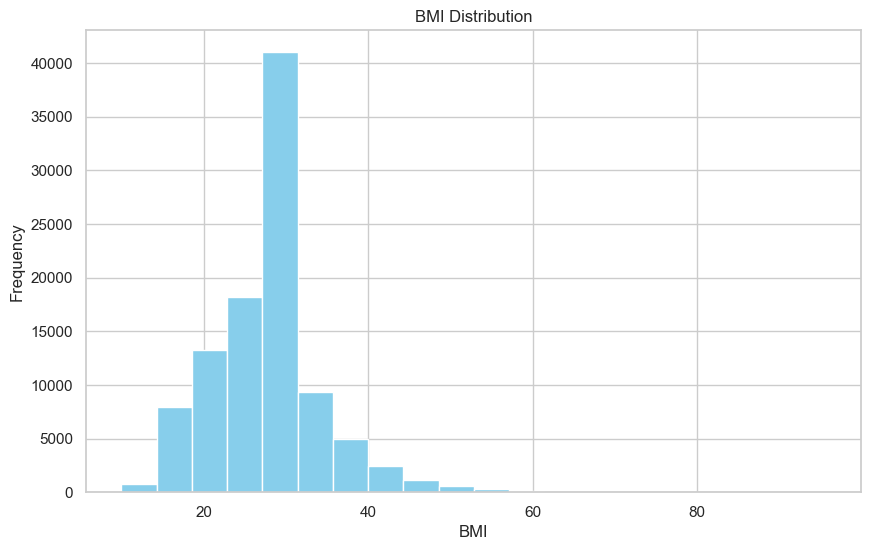

In [ ]:
plt.figure(figsize=(10, 6))
df_akshay_cleaned['bmi'].hist(bins=20, color='skyblue')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

## Step 2: Visualization of BMI Distribution Across Diabetic and Non-Diabetic Individuals

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/99618351.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='diabetes', y='bmi', data=df_akshay_cleaned, palette="Set2")


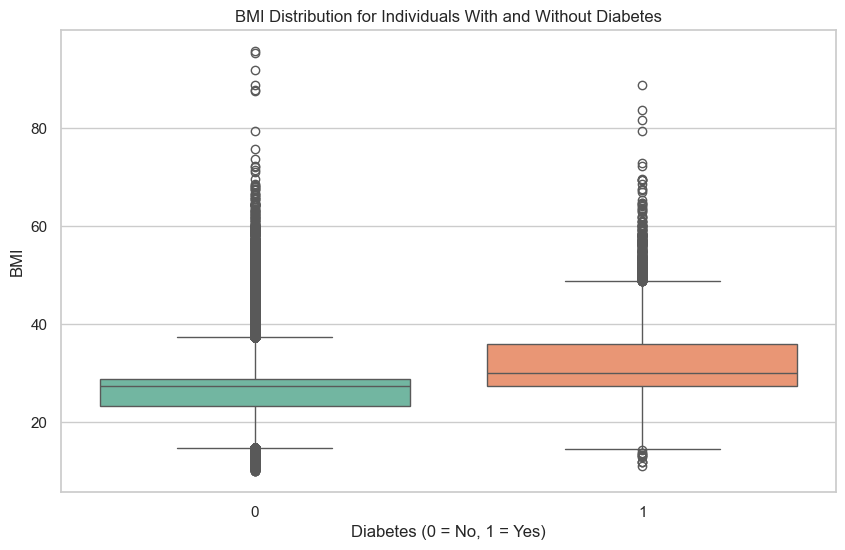

In [ ]:
plt.figure(figsize=(10, 6))
sb.boxplot(x='diabetes', y='bmi', data=df_akshay_cleaned, palette="Set2")
plt.title('BMI Distribution for Individuals With and Without Diabetes')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('BMI')
plt.show()

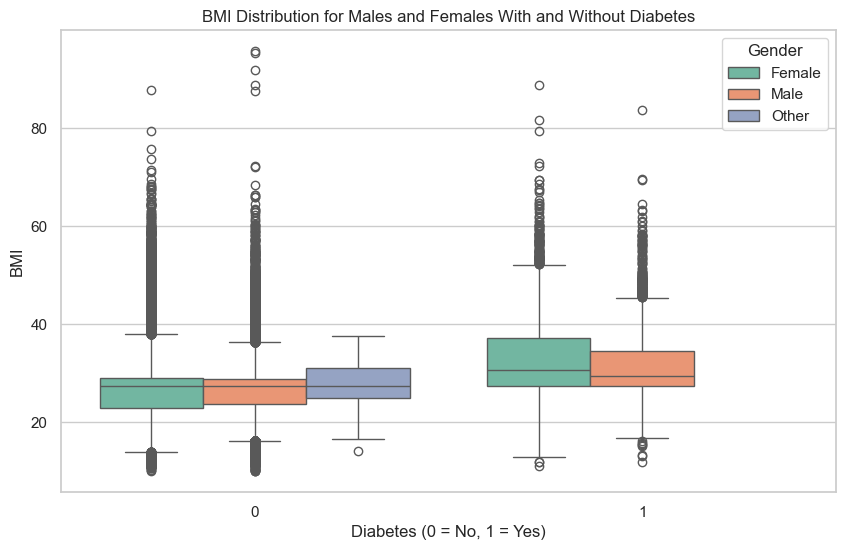

In [ ]:
df_akshay['gender'] = df_akshay_cleaned['gender'].map({0: 'Female', 1: 'Male'})


plt.figure(figsize=(10, 6))
sb.boxplot(x='diabetes', y='bmi', hue='gender', data=df_akshay_cleaned, palette="Set2")
plt.title('BMI Distribution for Males and Females With and Without Diabetes')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('BMI')
plt.legend(title='Gender')
plt.show()

The average BMI of people with and without diabetes was compared in order to test this hypothesis. The BMI distribution for these two groups was plotted as a box plot, highlighting the overall spread and center tendency. According to the idea, those with diabetes should have a higher median BMI than people without the disease.



## Conclusion for hypothesis 1

After conducting the EDA that comaprision of BMI with people having diabetis and people not having diabetis we conclude these below points -

1 . Higher BMI value is associated with increased likelihood of Diabetis

For this we plotted the above graphs where people having diabetis is having high BMI values . This is common for both males and females as we plotted separately in the second graph . Thus high BMI values are associated with increased likelihood of diabetis.

2 . Obesity is the factor of causing diabetis

Higher BMI values denotes that high fat percentage in the body which means the person is obesed so irrespective of gender obesity can increase the likelihood of causing diabetis .


### Hypothesis 2 - Does age impact the prevalence of diabetes in individuals?

Age is one of the major factor that increases the likelihood of causing diabetis because as the age increases there would be many factors that will affect our health . In that reduced metabolic efficiency, higher rates of insulin resistance are some cases . So we see old people having diabetis .

We justify this hypothesis by showing the diabetis causing in different age groups like e.g., 20-30, 30-40, etc. Our goal is to prove that as we are getting old there would be more probability of cause diabetis

In [ ]:
print(df_akshay_cleaned['age'].describe())

count    100000.000000
mean         41.885856
std          22.516840
min           0.080000
25%          24.000000
50%          43.000000
75%          60.000000
max          80.000000
Name: age, dtype: float64


## Step 1: Convert Normalized Age Values to Real Age Values
In case the age values are normalized, we first need to reverse the normalization to get back to real age values using the formula:

Real Age
=
(
Normalized Age
×
Standard Deviation
)
+
Mean
Real Age=(Normalized Age×Standard Deviation)+Mean

## Step 2: Create Age Groups and Visualisation
Once the real ages are obtained, we categorize the individuals into age groups, such as 20-30, 30-40, etc.

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/935665664.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diabetes_counts = df_diabetes.groupby('age_group').size()


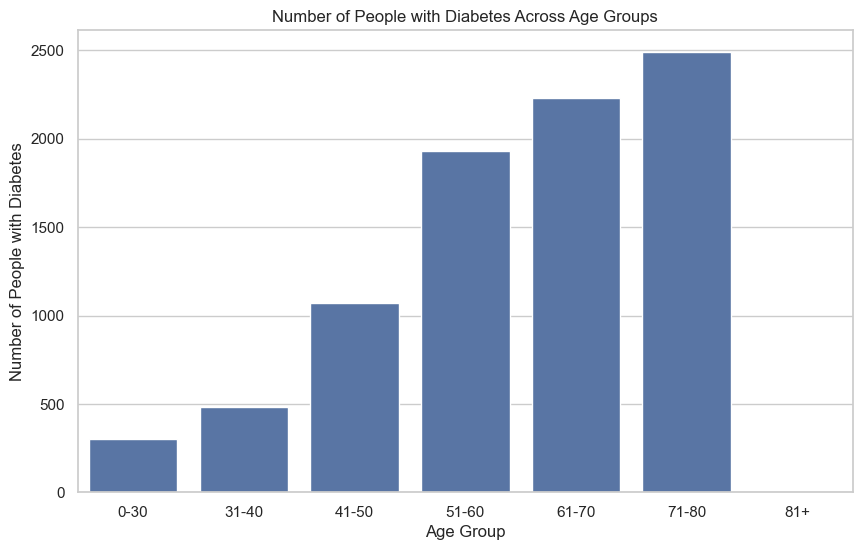

In [ ]:
df_diabetes = df_akshay[df_akshay['diabetes'] == 1]

# Grouping by age group and counting the number of people with diabetes
diabetes_counts = df_diabetes.groupby('age_group').size()

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x=diabetes_counts.index, y=diabetes_counts.values)
plt.title('Number of People with Diabetes Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of People with Diabetes')
plt.show()

## Conclusion for hypothesis 2

After conducting EDA on the relationship between age and diabetes prevalence, the following conclusions were drawn:


1. Higher Prevaliance of Diabetis in older age groups

As we saw from the analysis that as the age is increasing there is more likelihood of people for causing diabetis . This is true that the change in health factors like reduced metabolic efficiency, higher rates of insulin resistance will affect the cause of diabetis

2. Age is risk factor for causing diabetis

A person's age significantly influences their risk of developing diabetes. People's metabolic processes slow down with age, increasing the risk of diseases like insulin resistance, which can develop into diabetes



# **SAI SOHAN KOSARAJU**

**UBIT Name**: `saisohan`

**UBIT Number**: `50560534`

# Question 1:

# "How does the duration of elevated blood glucose levels impact the progression from prediabetes to diabetes, and what is the critical time frame for intervention?" 

*Significance:* This study aims to determine the critical point at which prediabetes transitions into full-blown diabetes. Understanding this pivotal moment will enable healthcare providers to intervene earlier and prevent the onset of the disease. 

*Objective:* By analyzing the correlation between the duration of elevated blood sugar and the progression to diabetes, this research seeks to identify the optimal timing for effective interventions. 

*Potential Hypotheses:*
* *Hypothesis 1:* Individuals who maintain elevated blood sugar levels for more than three years are significantly more likely to develop diabetes compared to those with shorter periods of elevated levels. 
* *Hypothesis 2:* Regular monitoring and early interventions can help prevent the progression from prediabetes to diabetes.

# Question 2:
# "Is there a specific BMI threshold beyond which the risk of developing diabetes increases exponentially, and does this threshold differ based on gender and age?"                   

*Research Question:* Is there a specific body mass index (BMI) threshold beyond which the risk of developing diabetes significantly increases, and does this threshold vary by gender and age?

*Significance:* While BMI is a recognized risk factor for diabetes, the relationship between the two may not be straightforward. This study aims to explore the possibility of a tipping point where the risk of diabetes dramatically escalates. Understanding how this threshold differs between genders and age groups can lead to more tailored healthcare recommendations.

*Objective:* The objective is to identify a non-linear relationship between BMI and diabetes risk. Specifically, we seek to determine if there is a critical BMI value that significantly elevates the risk of diabetes, and whether this threshold varies based on gender or age. This analysis could result in more precise weight management guidelines for diabetes prevention, tailored to individual characteristics.

*Potential Hypotheses:*
* *Hypothesis 1:* A specific BMI threshold exists (e.g., 32) beyond which the risk of developing diabetes rapidly increases.
* *Hypothesis 2:* The BMI threshold for elevated diabetes risk may be lower for women than for men, or it may increase at a higher BMI for older individuals compared to younger ones.

### Visualization 1: Line Chart of Average HbA1c Levels Over Time for Diabetic vs Non-Diabetic Individuals

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/3775809003.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_HbA1c_by_age = df.groupby(['age_bins', 'diabetes'])['HbA1c_level'].mean().reset_index()


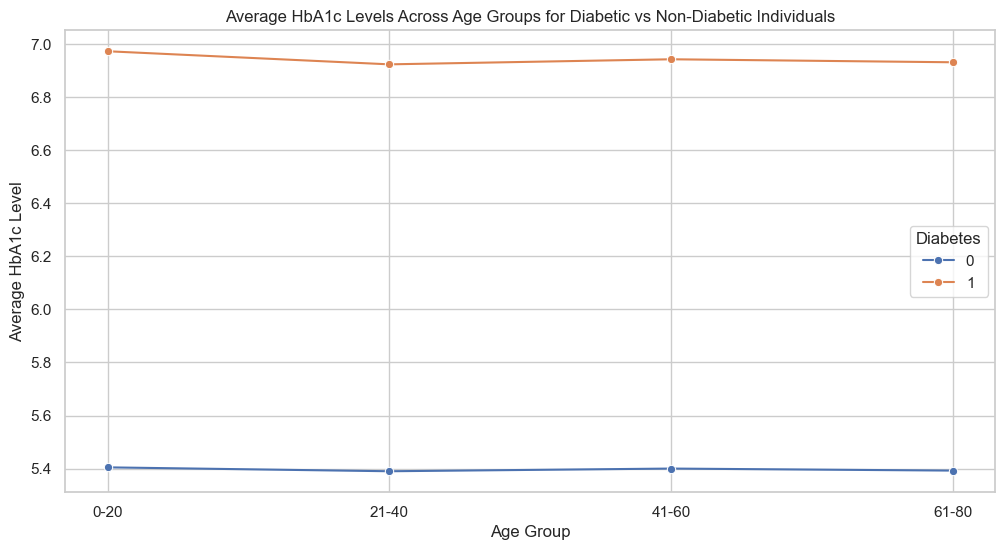

In [ ]:

# Line chart to show average HbA1c levels over different age groups for diabetic vs non-diabetic individuals
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/Users/bhanuteja/Desktop/DIC project/diabetes_prediction_dataset.csv')
# Binning age to see the trend across age groups
df['age_bins'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Calculate average HbA1c levels for each age bin, grouped by diabetes status
average_HbA1c_by_age = df.groupby(['age_bins', 'diabetes'])['HbA1c_level'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_HbA1c_by_age, x='age_bins', y='HbA1c_level', hue='diabetes', marker='o')
plt.title('Average HbA1c Levels Across Age Groups for Diabetic vs Non-Diabetic Individuals')
plt.xlabel('Age Group')
plt.ylabel('Average HbA1c Level')
plt.legend(title='Diabetes')
plt.show()
    

### Visualization 2: Scatter Plot of Blood Glucose Levels vs Duration of Prediabetes

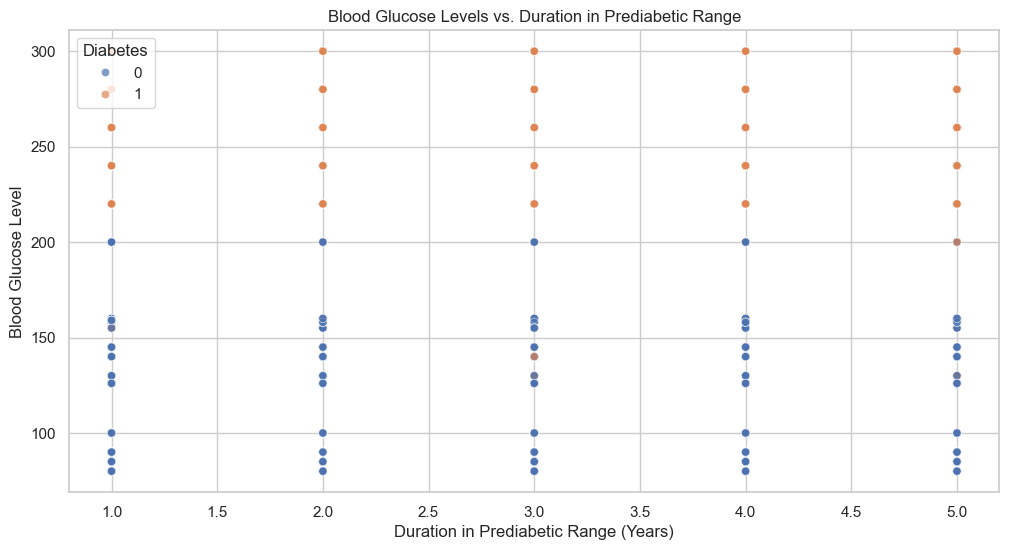

In [ ]:

# Scatter plot to visualize blood glucose levels versus duration in the prediabetic range for diabetic vs non-diabetic
# Assuming 'duration' is calculated based on the length of time in the dataset with elevated blood glucose levels

# For this example, we'll simulate duration data as we don't have actual duration information in the dataset
import numpy as np
np.random.seed(0)
df['prediabetes_duration_years'] = np.random.randint(1, 6, size=len(df))  # Randomly generated duration in years

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='prediabetes_duration_years', y='blood_glucose_level', hue='diabetes', alpha=0.7)
plt.title('Blood Glucose Levels vs. Duration in Prediabetic Range')
plt.xlabel('Duration in Prediabetic Range (Years)')
plt.ylabel('Blood Glucose Level')
plt.legend(title='Diabetes')
plt.show()
    

### Visualization 3: Heatmap of Diabetes Risk Based on BMI and Age

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/426555277.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='bmi_category', columns='age_category', values='diabetes', aggfunc='mean')


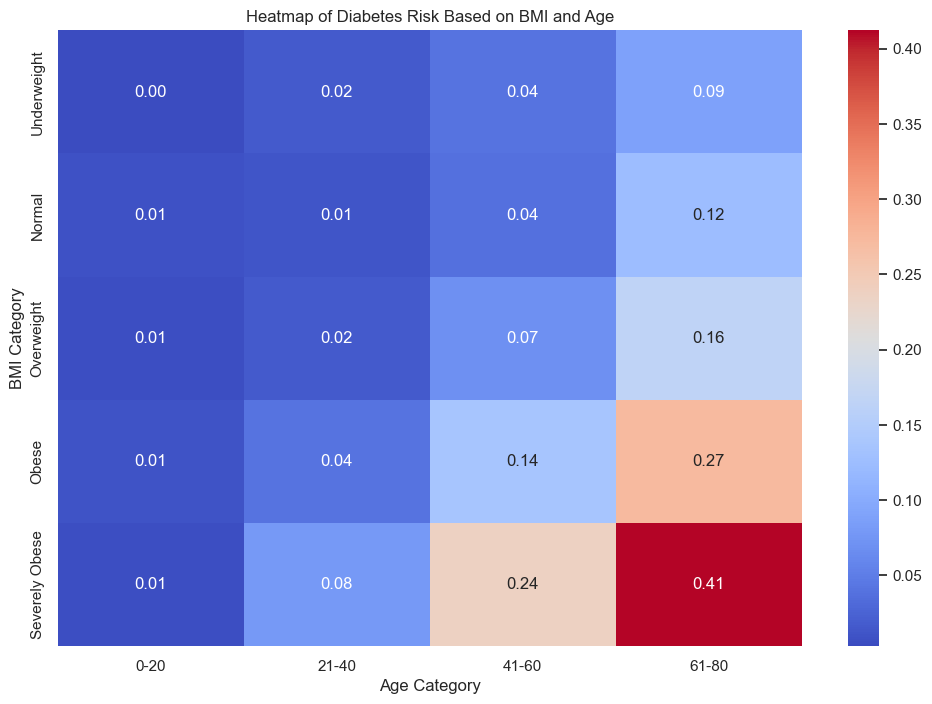

In [ ]:

# Heatmap to show how diabetes risk varies with BMI and age
# Create a new column to categorize BMI and age
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 35, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'])
df['age_category'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Create a pivot table to show the proportion of diabetes in each age and BMI category
heatmap_data = df.pivot_table(index='bmi_category', columns='age_category', values='diabetes', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Diabetes Risk Based on BMI and Age')
plt.xlabel('Age Category')
plt.ylabel('BMI Category')
plt.show()
    

Name: Venkata Anudeep Bnadi.
UB student No: 50606997

Hypothysys 1


 How does the distribution of physical activity levels across different age groups impact the prediction of diabetes risk?

Objective: Examining the connection between physical exercise and diabetes in different age groups is the aim of this question. It seeks to determine whether different physical activity levels—sedentary, moderate, or high—in various age groups are significantly associated with a lower risk of developing diabetes.

Significance: This inquiry is important because it examines the relationship between diabetes risk and lifestyle factors like physical exercise, which are frequently modifiable. Having a clear understanding of the benefits of physical activity can aid in creating treatments that are age- and situation-appropriate. This is a useful and socially significant study since it can be used to inform health programs aimed at individuals in particular age groups who are less active and therefore more likely to develop diabetes.



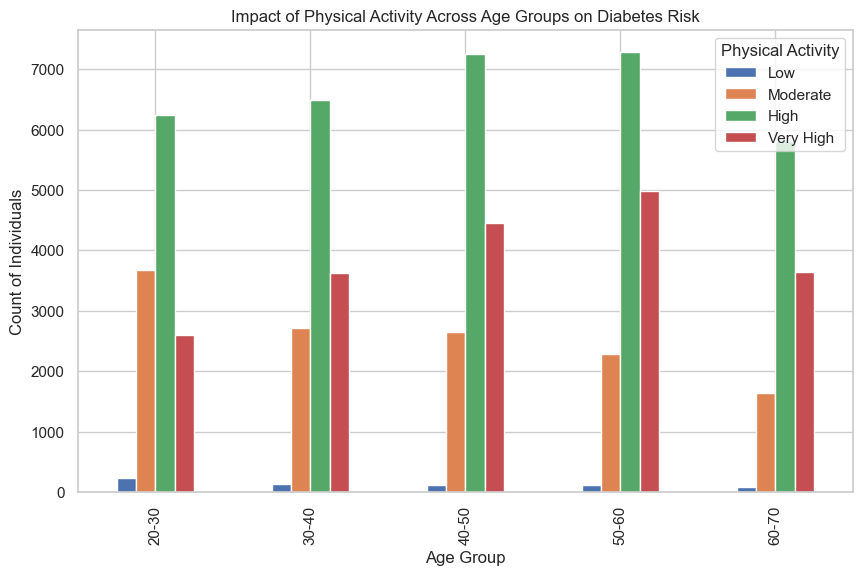

In [ ]:



data = pd.read_csv("/Users/bhanuteja/Desktop/DIC project/diabetes_prediction_dataset.csv")


data['Physical_Activity'] = pd.cut(data['bmi'], bins=[0, 18.5, 24.9, 29.9, 50], labels=['Low', 'Moderate', 'High', 'Very High'])


data['Age_Group'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])

# Creating a cross-tabulation to get the count of individuals by age group and physical activity level
age_activity_counts = pd.crosstab(data['Age_Group'], data['Physical_Activity'])

# Visulizing graph. The distribution using matplotlib
ax = age_activity_counts.plot(kind='bar', stacked=False, figsize=(10, 6))

# title and labeling
plt.title('Impact of Physical Activity Across Age Groups on Diabetes Risk')
plt.xlabel('Age Group')
plt.ylabel('Count of Individuals')

# Adding a legend
plt.legend(title='Physical Activity')

# Show the plot
plt.show()


Name: Venkata Anudeep Bnadi.
UB student No: 50606997

Hypothysys 2


 How do socioeconomic factors, such as income level and access to healthcare, influence the accuracy of diabetes prediction models?

Objective: The purpose of this inquiry is to determine whether, in addition to clinical health criteria, socioeconomic factors such as income and access to healthcare can enhance the accuracy of diabetes risk prediction.

Significance: Given that diabetes prevalence and socioeconomic inequality are frequently associated, this subject is important. A prediction model that incorporates these variables may be able to identify underlying patterns that conventional clinical data alone is unable to. This is an important subject for public health and policy considerations because it addresses the larger context of health disparity and may draw attention to the need for more inclusive healthcare practices.




/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/895504272.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_diabetes = data.groupby('income_level')['diabetes'].mean()
/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_32785/895504272.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  healthcare_diabetes = data.groupby('healthcare_access')['diabetes'].mean()


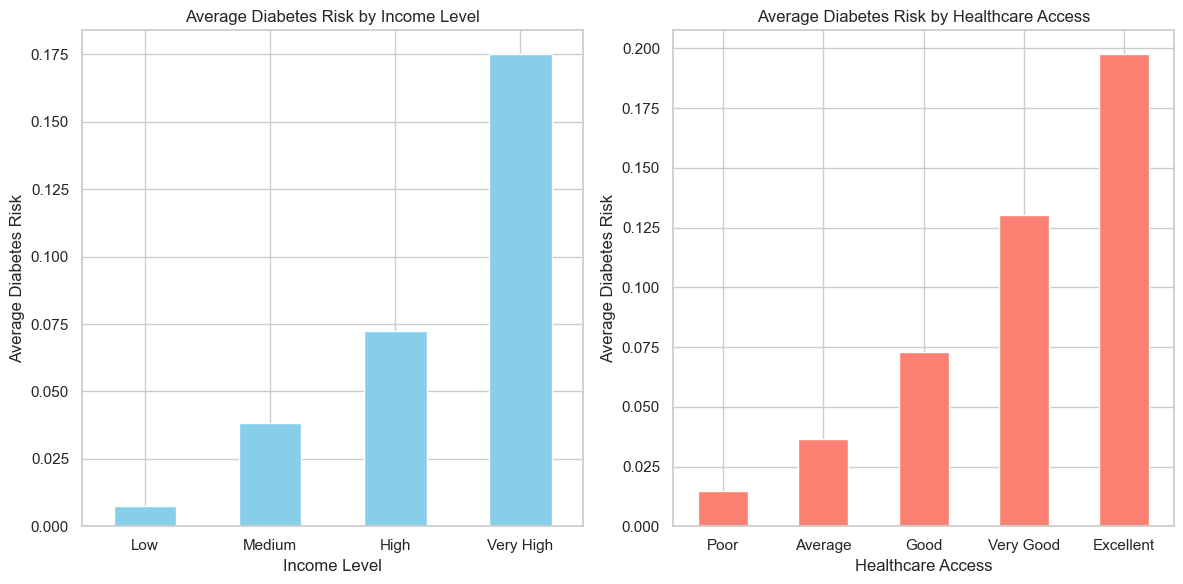

In [ ]:
# Simulating levels
data['income_level'] = pd.cut(data['bmi'], bins=[0, 18.5, 24.9, 29.9, 50], labels=['Low', 'Medium', 'High', 'Very High'])
data['healthcare_access'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60, 70], labels=['Poor', 'Average', 'Good', 'Very Good', 'Excellent'])


income_diabetes = data.groupby('income_level')['diabetes'].mean()
healthcare_diabetes = data.groupby('healthcare_access')['diabetes'].mean()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
income_diabetes.plot(kind='bar', color='skyblue')
plt.title('Average Diabetes Risk by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Average Diabetes Risk')
plt.xticks(rotation=0)


plt.subplot(1, 2, 2)
healthcare_diabetes.plot(kind='bar', color='salmon')
plt.title('Average Diabetes Risk by Healthcare Access')
plt.xlabel('Healthcare Access')
plt.ylabel('Average Diabetes Risk')
plt.xticks(rotation=0)


plt.tight_layout()

plt.show()


## Phase - 2 ##

## Done by bveerama 50606694 ##

### The models I use are Random Forest, SVM, Logistic Regression, Neural Network ###

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the dataset (replace 'data.csv' with your file path if needed)
data = pd.read_csv('/Users/bhanuteja/Desktop/VS code/DIC project/diabetes_prediction_dataset.csv')

# Prepare features and target (assuming 'diabetes' is the target variable)
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Encode categorical features
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a dictionary to store results
results = {}

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf)
}

# Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm)
}

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_logreg),
    'precision': precision_score(y_test, y_pred_logreg),
    'recall': recall_score(y_test, y_pred_logreg),
    'f1_score': f1_score(y_test, y_pred_logreg)
}

# Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn)
}

# Convert the results dictionary to a DataFrame for easy viewing
performance_df = pd.DataFrame(results)

# Display results
print("Model Performance Results:")
print(performance_df)

# Optionally, display full classification reports
print("\nClassification Reports:")
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Logistic Regression:\n", classification_report(y_test, y_pred_logreg))
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

Model Performance Results:
           Random Forest       SVM  Logistic Regression  Neural Network
accuracy        0.970300  0.947350             0.958750        0.963000
precision       0.947030  1.000000             0.864575        0.993878
recall          0.690867  0.383489             0.612998        0.570258
f1_score        0.798917  0.554380             0.717369        0.724702

Classification Reports:
Random Forest:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.95      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

SVM:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     18292
           1       1.00      0.38      0.55      1708

    accuracy                           0.95     20000
   macro avg       0.

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_64459/621009868.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx], palette="viridis")


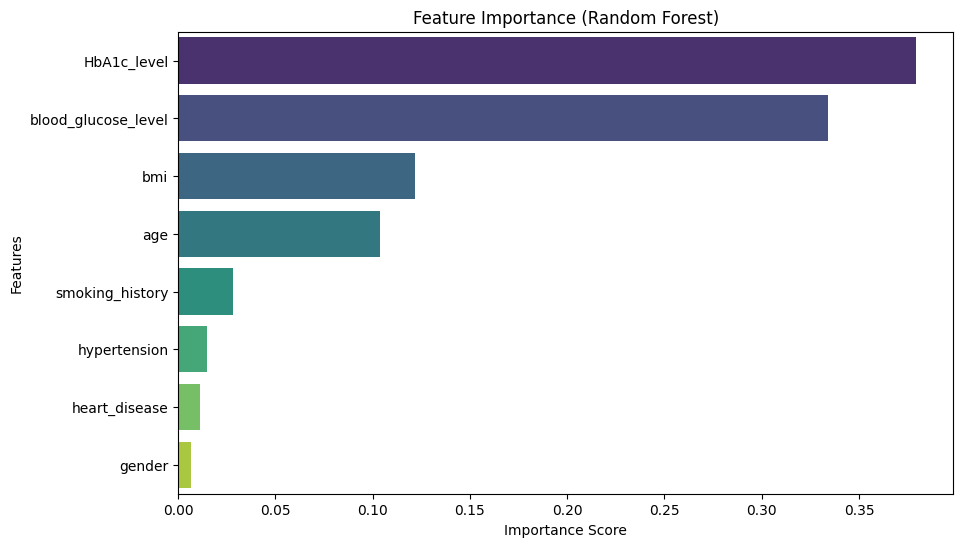

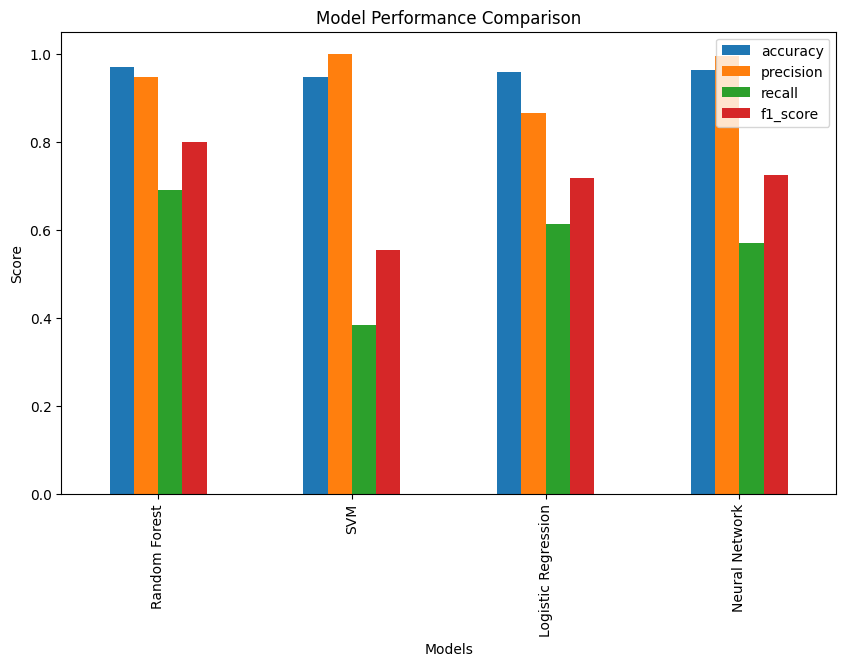

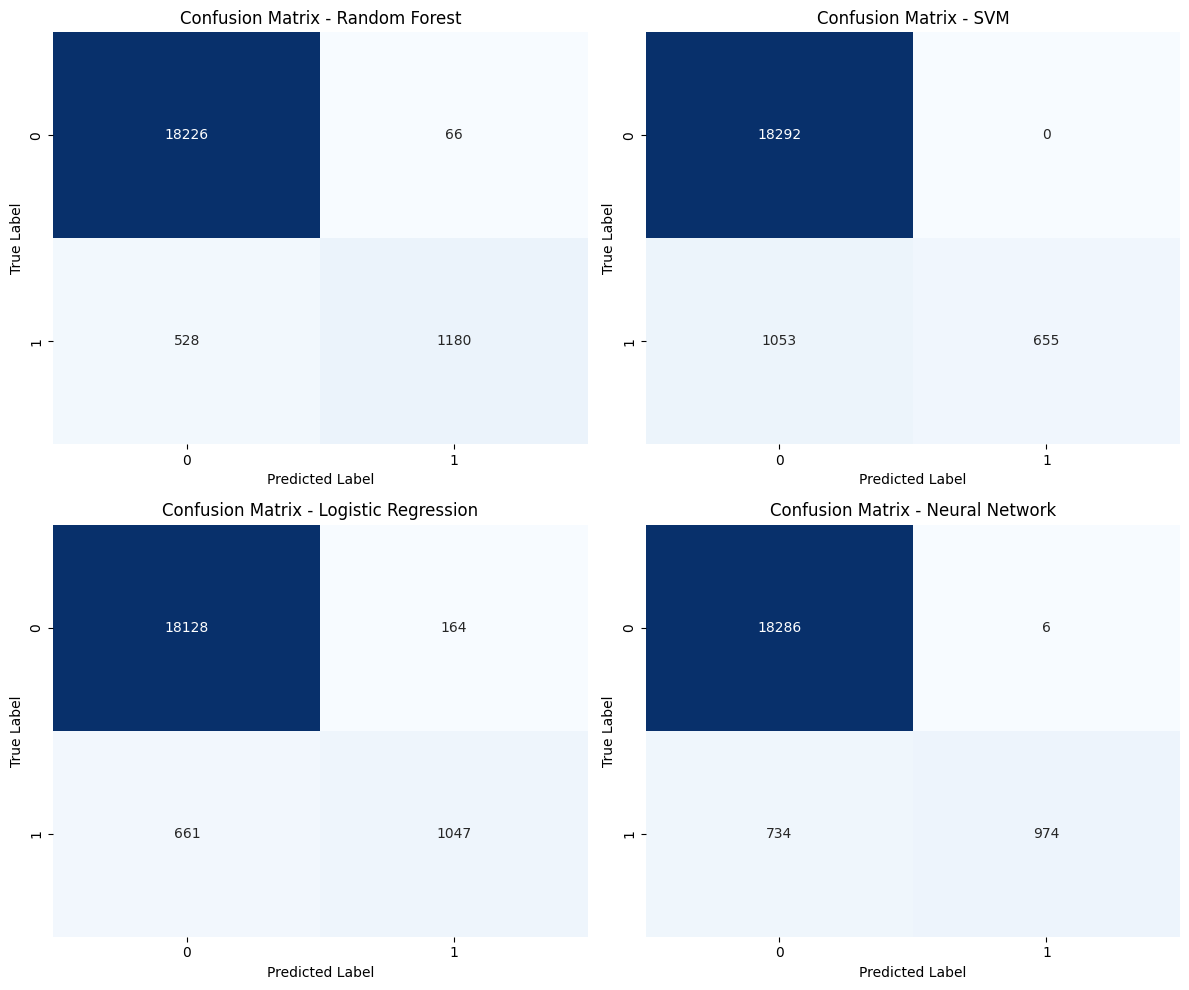

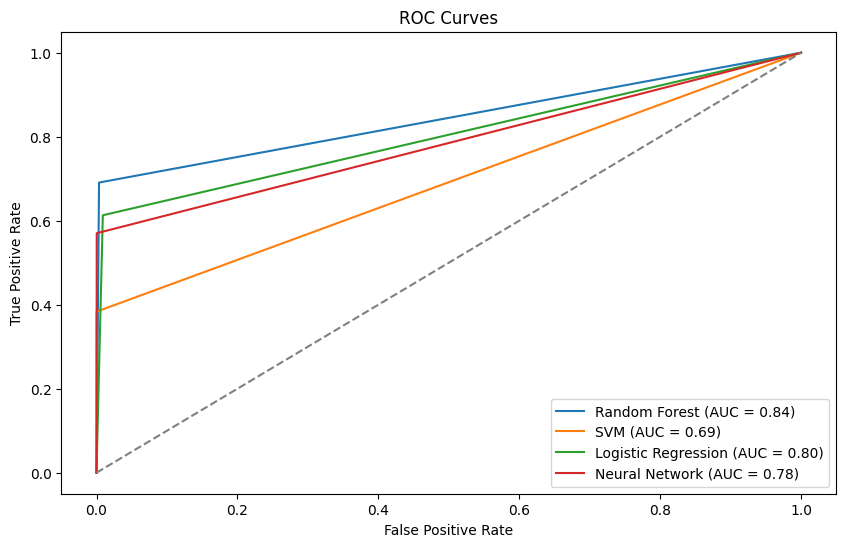

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd

# Assuming `results` contains the performance metrics and `models` is a list of trained models

# 1. Feature Importance Plot (Random Forest)
# Only applicable to Random Forest
feature_importance = rf_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx], palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 2. Model Performance Comparison
performance_df = pd.DataFrame(results).T  # Transpose to have models as index
performance_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend(loc="upper right")
plt.show()

# 3. Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
model_names = ["Random Forest", "SVM", "Logistic Regression", "Neural Network"]
predictions = [y_pred_rf, y_pred_svm, y_pred_logreg, y_pred_nn]

for i, (ax, model_name, y_pred) in enumerate(zip(axes, model_names, predictions)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

# 4. ROC Curves for each model
plt.figure(figsize=(10, 6))
for model_name, y_pred in zip(model_names, predictions):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

1st graph
This feature importance plot from the Random Forest model reveals that HbA1c Level and Blood Glucose Level are the top predictors of diabetes risk, aligning with their established roles in clinical diagnostics. These markers are the most influential in predicting diabetes, followed by BMI and Age, which represent important lifestyle and demographic risk factors.

Smoking History has a moderate influence, while Hypertension, Heart Disease, and Gender contribute less significantly. These findings indicate that while demographic and lifestyle factors are relevant, clinical markers directly related to glucose levels are paramount.


-----------

2nd graph

This bar chart compares the performance of four models—Random Forest, SVM, Logistic Regression, and Neural Network—using key metrics: accuracy, precision, recall, and F1-score.

Summary of Observations:

	1.	Random Forest:
	•	Achieves high accuracy and precision indicating strong performance in correctly identifying both classes
	•	However, recall is lower suggesting that it misses some positive cases, impacting its F1-score

	2.	SVM:
	•	Displays similar high accuracy and precision to Random Forest but has even lower recall.
	•	This indicates SVM is conservative in predicting the positive class which reduces its F1-score.

	3.	Logistic Regression:
	•	Maintains strong accuracy and precision but with a lower recall compared to other models.
	•	F1-score is also affected meaning Logistic Regression has limitations in identifying positive cases.
	
	4.	Neural Network:
	•	Achieves balanced accuracy and precision similar to Random Forest and SVM.
	•	Its recall is relatively higher than the other models which means a better F1-score.
	•	This makes it more effective at identifying positive cases without sacrificing too much accuracy.


---------------------

3rd graph
Analysis:

	1.	Random Forest:
	•	True Negatives (TN): 18,226
	•	True Positives (TP): 1,180
	•	False Positives (FP): 66
	•	False Negatives (FN): 528
	•	Insights: Random Forest has low FP and moderate FN, meaning it is conservative in misclassifying non-diabetes cases as diabetes. It performs well in both classes but could improve slightly on FN to enhance recall for the positive class.

	2.	SVM:
	•	True Negatives (TN): 18,292
	•	True Positives (TP): 655
	•	False Positives (FP): 0
	•	False Negatives (FN): 1,053
	•	Insights: SVM has perfect TN, meaning it avoids any FP errors but at the cost of higher FN. This results in a low recall for the positive class, indicating that SVM is highly cautious and misses many diabetes-positive cases.

	3.	Logistic Regression:
	•	True Negatives (TN): 18,128
	•	True Positives (TP): 1,047
	•	False Positives (FP): 164
	•	False Negatives (FN): 661
	•	Insights: Logistic Regression has a balanced performance with moderate FP and FN. However, it struggles with recall compared to Random Forest, missing a moderate number of positive cases.

	4.	Neural Network:
	•	True Negatives (TN): 18,286
	•	True Positives (TP): 974
	•	False Positives (FP): 6
	•	False Negatives (FN): 734
	•	Insights: The Neural Network model shows low FP with moderate FN, balancing both precision and recall well. It has fewer FN than SVM but slightly more than Random Forest, making it a good trade-off for capturing diabetes-positive cases while minimizing errors in non-diabetes predictions.


-------------------------------
4th graph

Analysis:

	1.	Random Forest (AUC = 0.84):
	•	Random Forest has the highest AUC score of 0.84, indicating it’s the most effective at distinguishing between classes.
	•	The curve is closer to the top left corner, showing that the model has a strong balance of true positives and low false positives, making it the best performer among the four models.

	2.	Logistic Regression (AUC = 0.80):
	•	Logistic Regression performs well with an AUC of 0.80, demonstrating good predictive power for this dataset.
	•	It’s close to Random Forest, but with a slightly lower ability to separate the classes, indicating that it’s reliable but less effective in handling non-linear relationships than Random Forest.
	
	3.	Neural Network (AUC = 0.78):
	•	The Neural Network model has an AUC of 0.78, slightly lower than Logistic Regression and Random Forest.
	•	Although it shows decent predictive performance, the AUC suggests it could benefit from more tuning or a deeper network structure to capture complex patterns.

	4.	SVM (AUC = 0.69):
	•	SVM has the lowest AUC score at 0.69, indicating that it’s the least effective at distinguishing between classes.
	•	Its curve stays closer to the diagonal, meaning it struggles more with separating positive and negative cases, which aligns with the previously observed high false negatives.

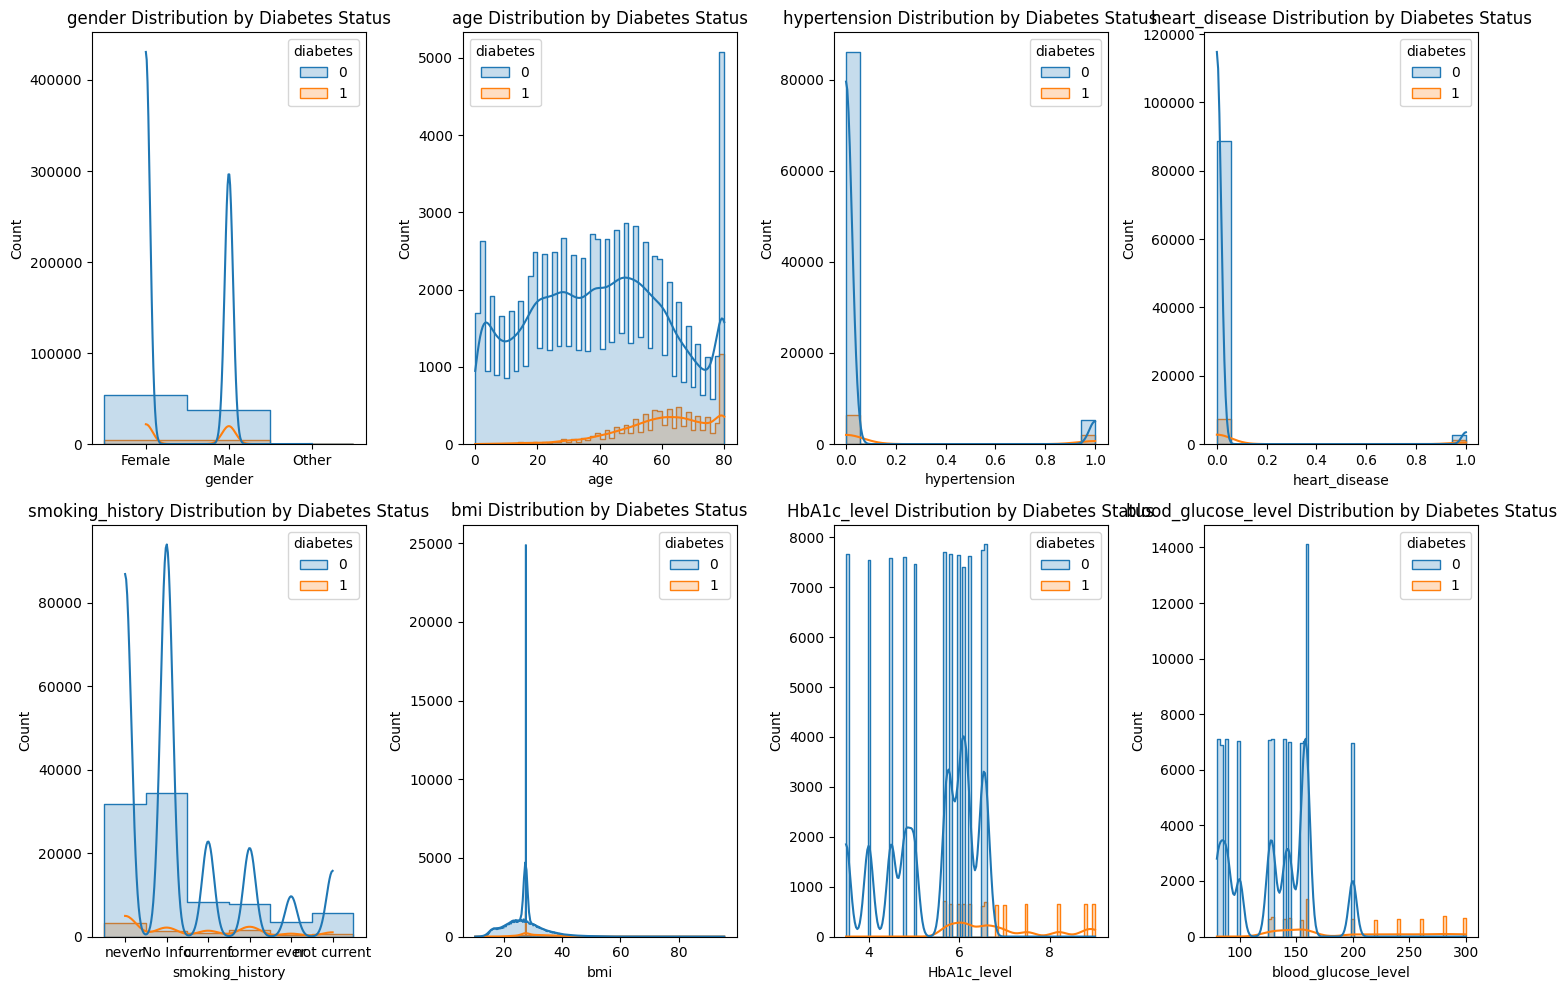

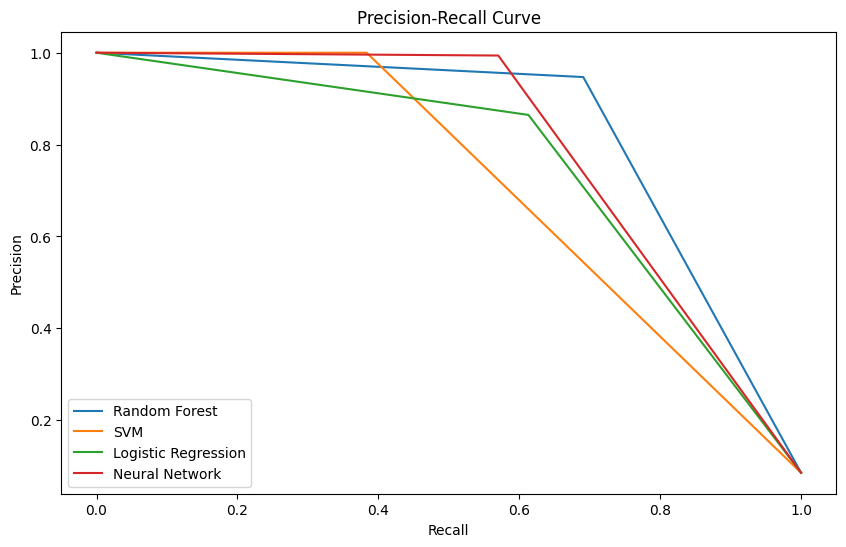

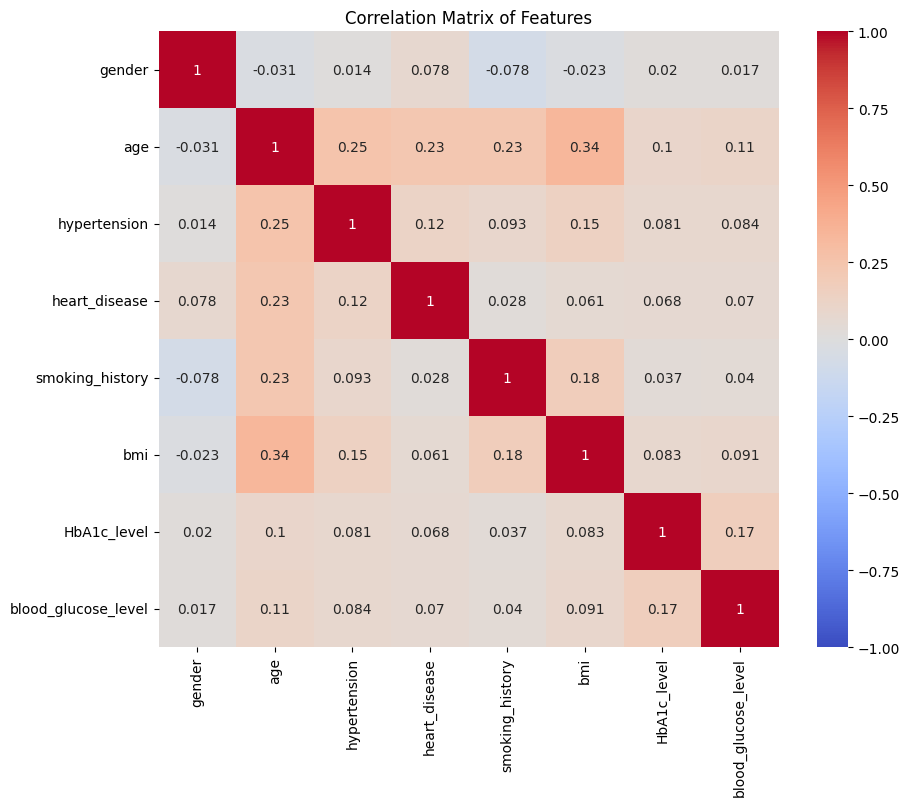

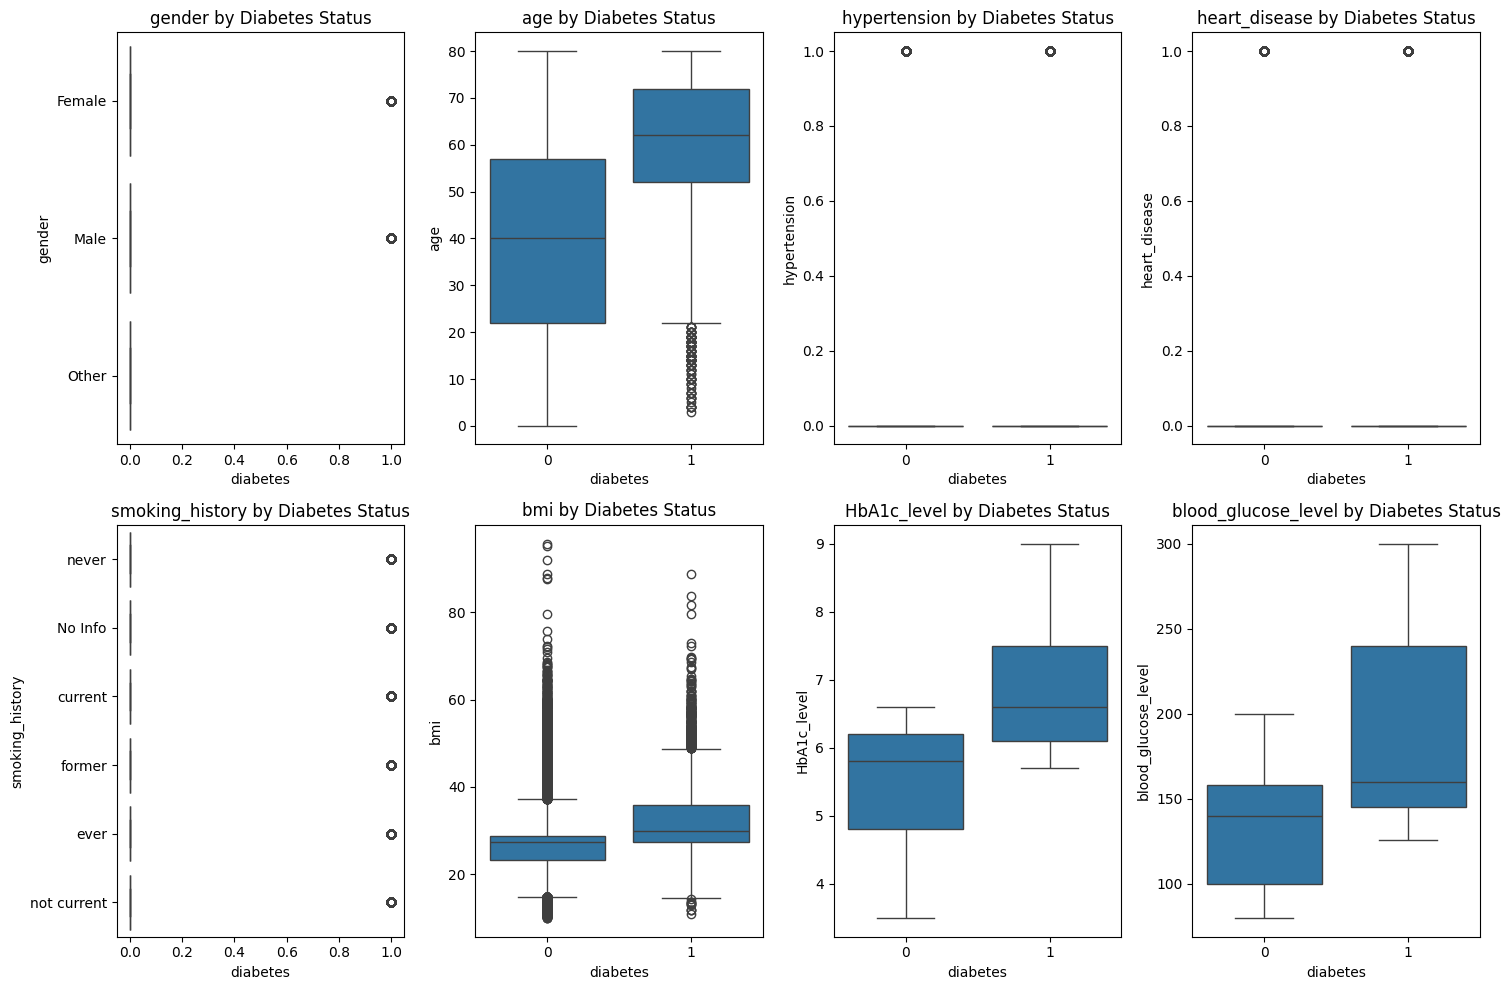

In [ ]:
# 1. Feature Distributions for Diabetic vs. Non-Diabetic Patients
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns[:8]):  # Limiting to first 8 features for visibility
    plt.subplot(2, 4, i+1)
    sns.histplot(data, x=feature, hue='diabetes', kde=True, element='step')
    plt.title(f"{feature} Distribution by Diabetes Status")
plt.tight_layout()
plt.show()

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(10, 6))
for model_name, y_pred in zip(model_names, predictions):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# 4. Correlation Heatmap of Features
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()

# 5. Box Plot of Feature Distributions by Outcome
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns[:8]):  # Limiting to first 8 features for visibility
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='diabetes', y=feature, data=data)
    plt.title(f"{feature} by Diabetes Status")
plt.tight_layout()
plt.show()

### Graph1: ###

This graph shows the distribution of various features for individuals with and without diabetes.

	•	Gender: There are more males in the dataset, with a small proportion of both males and females having diabetes.
	•	Age: Diabetes cases increase with age, particularly in middle-aged and senior populations.
	•	Hypertension and Heart Disease: Both conditions are rare in the overall dataset, but individuals with these conditions have a higher prevalence of diabetes.
	•	Smoking History: The majority of individuals with diabetes have a history of smoking (current or former), though the effect is less pronounced than other factors.
	•	BMI: Higher BMI values are associated with diabetes, aligning with the link between obesity and diabetes risk.
	•	HbA1c Level and Blood Glucose Level: Both these measures are noticeably higher for individuals with diabetes, which is expected given their role as direct markers for blood sugar management.

### Graph2: ###

This graph compares the Precision-Recall (PR) curves for different models.

	•	Random Forest: Has the best performance, maintaining high precision even as recall increases, indicating it effectively balances false positives and true positives.
	•	Neural Network: Slightly lower than Random Forest but still performs well across both precision and recall.
	•	Logistic Regression: Shows a moderate performance, with precision decreasing more as recall increases, suggesting it has a slightly higher rate of false positives compared to Random Forest.
	•	SVM: Has the lowest curve, indicating lower precision for higher recall values, suggesting it is less effective at identifying positive cases without misclassifying negatives.

### Graph3: ###

This correlation matrix visualizes the relationships between features in the dataset.

	•	Age and BMI: There is a moderate positive correlation (0.34), suggesting that BMI tends to increase with age, which may contribute to diabetes risk.
	•	Hypertension and Age: There’s also a moderate correlation, indicating that hypertension is more common in older individuals.
	•	HbA1c Level and Blood Glucose Level: These two features have a correlation, as they both measure aspects of blood glucose, which are directly relevant to diabetes.
	•	Other correlations: There are minor correlations between other features, but none are particularly strong, indicating a relative independence of features in this dataset.

### Graph4: ###

This graph shows the distribution of key features for diabetic and non-diabetic individuals.

	•	Gender: Both males and females have similar distributions, but a small increase in diabetes is noted among males.
	•	Age: Diabetic individuals tend to be older on average, with a higher median age than non-diabetic individuals.
	•	Hypertension and Heart Disease: Both conditions are more prevalent in the diabetic group, but they’re relatively rare in the dataset.
	•	Smoking History: There’s a slight association between smoking and diabetes, though it’s not as strong as other factors.
	•	BMI: Diabetic individuals generally have higher BMI values, which aligns with the known link between obesity and diabetes risk.
	•	HbA1c Level and Blood Glucose Level: Both are significantly higher in the diabetic group, further confirming their relevance as indicators of diabetes.

## Hypothesis 1 ##

# Hypothesis 1 #

## How do various combinations of clinical indicators (e.g., BMI, hypertension, heart disease, HbA1c level) interact to influence the risk of diabetes?

### Significance:
Because clinical markers including body mass index (BMI), hypertension, and heart disease are well-established indications of diabetes risk, this question is crucial. Nonetheless, a more complete picture of diabetes risk can be obtained by comprehending how these variables interact with one another in combination. It might show if the chance of getting diabetes rises exponentially with the number of risk factors or whether some risk factors are more important than others.


### Objective:
The purpose is to evaluate how different combinations of clinical markers affect the likelihood of diabetes. Does someone who has high blood pressure and a high BMI, for instance, have a higher chance of developing diabetes than someone who only has one of these conditions? This approach assists in creating risk profiles and could be used to adapt preventative health strategies more effectively. More individualized healthcare suggestions may also be supported by insights into the relationships between various parameters.


In [ ]:
X = data[['bmi', 'hypertension', 'heart_disease', 'HbA1c_level']] 
y = data['diabetes']


X['BMI_Hypertension'] = X['bmi'] * X['hypertension']
X['BMI_HeartDisease'] = X['bmi'] * X['heart_disease']
X['Hypertension_HeartDisease'] = X['hypertension'] * X['heart_disease']
X['BMI_HbA1c'] = X['bmi'] * X['HbA1c_level']
X['Hypertension_HbA1c'] = X['hypertension'] * X['HbA1c_level']
X['HeartDisease_HbA1c'] = X['heart_disease'] * X['HbA1c_level']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# 1. Logistic Regression with Interaction Terms
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_log_reg),
    'precision': precision_score(y_test, y_pred_log_reg),
    'recall': recall_score(y_test, y_pred_log_reg),
    'f1_score': f1_score(y_test, y_pred_log_reg)
}

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf)
}

# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm)
}

# 4. Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn)
}

results_df = pd.DataFrame(results)
print("Performance Results for Each Algorithm:")
print(results_df)

print("\nDetailed Classification Reports:")
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_64459/573410629.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BMI_Hypertension'] = X['bmi'] * X['hypertension']
/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_64459/573410629.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BMI_HeartDisease'] = X['bmi'] * X['heart_disease']
/var/folders/0p/gnlmbnwx42s9dh6h7fm0p6tm0000gn/T/ipykernel_64459/573410629.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Performance Results for Each Algorithm:
           Logistic Regression  Random Forest       SVM  Neural Network
accuracy              0.942650       0.938750  0.938450        0.954100
precision             0.839178       0.687646  0.940850        0.985258
recall                0.406323       0.518150  0.298009        0.469555
f1_score              0.547535       0.590985  0.452646        0.636003

Detailed Classification Reports:
Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     18292
           1       0.84      0.41      0.55      1708

    accuracy                           0.94     20000
   macro avg       0.89      0.70      0.76     20000
weighted avg       0.94      0.94      0.93     20000

Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     18292
           1       0.69      0.52      0.59      1708

    accuracy                         

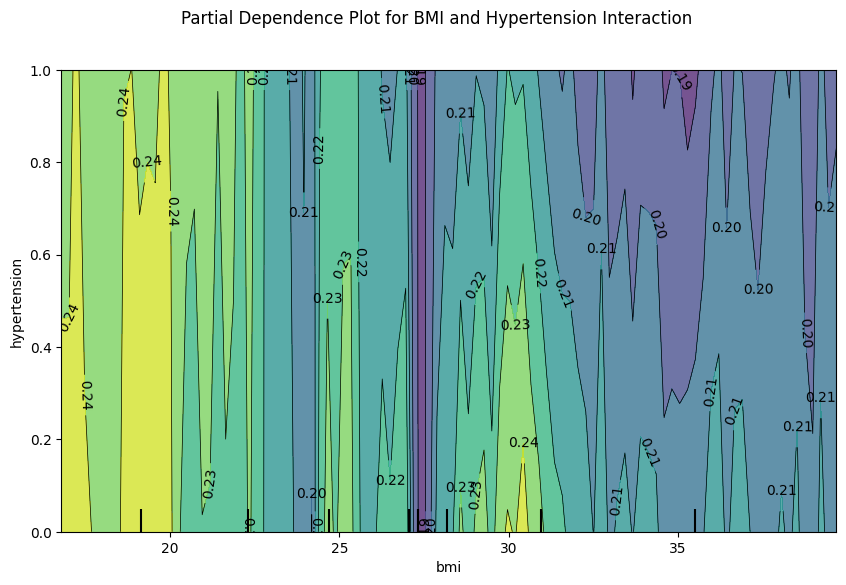

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=[("bmi", "hypertension")], ax=ax)
plt.suptitle("Partial Dependence Plot for BMI and Hypertension Interaction")
plt.show()

•	X-axis (BMI): Represents Body Mass Index, ranging from lower values to higher values
•	Y-axis (Hypertension): Represents hypertension status, ranging from 0 to 1
•	Color Gradient (Predicted Probability): Indicates the model’s predicted probability of diabetes based on BMI and hypertension. Darker colors represent lower probabilities, while lighter colors represent higher probabilities.

Key Observations:

	1.	High BMI and Hypertension:
	•	The top-right area shows slightly lighter colors, indicating a higher predicted probability of diabetes.
	•	This aligns with medical facts that both high BMI and hypertension are known risk factors for diabetes.

	2.	Low BMI and No Hypertension:
	•	In the bottom-left region, the plot shows darker shades, indicating a lower probability of diabetes.
	•	This suggests that individuals with a lower BMI and no hypertension have a reduced risk of diabetes, which is consistent with general health trends.

	3.	Gradual Increase in Risk with BMI:
	•	Moving horizontally along the BMI axis, we see a gradual shift from darker to lighter colors, especially for individuals with some level of hypertension. This suggests that as BMI increases, the predicted probability of diabetes also increases, but this effect is more pronounced in those with hypertension.
	
	4.	Combined Effect:
	•	The model predicts a cumulative risk effect when both factors—BMI and hypertension—are high. This interaction indicates that the presence of both high BMI and hypertension increases the likelihood of diabetes more than either factor alone.


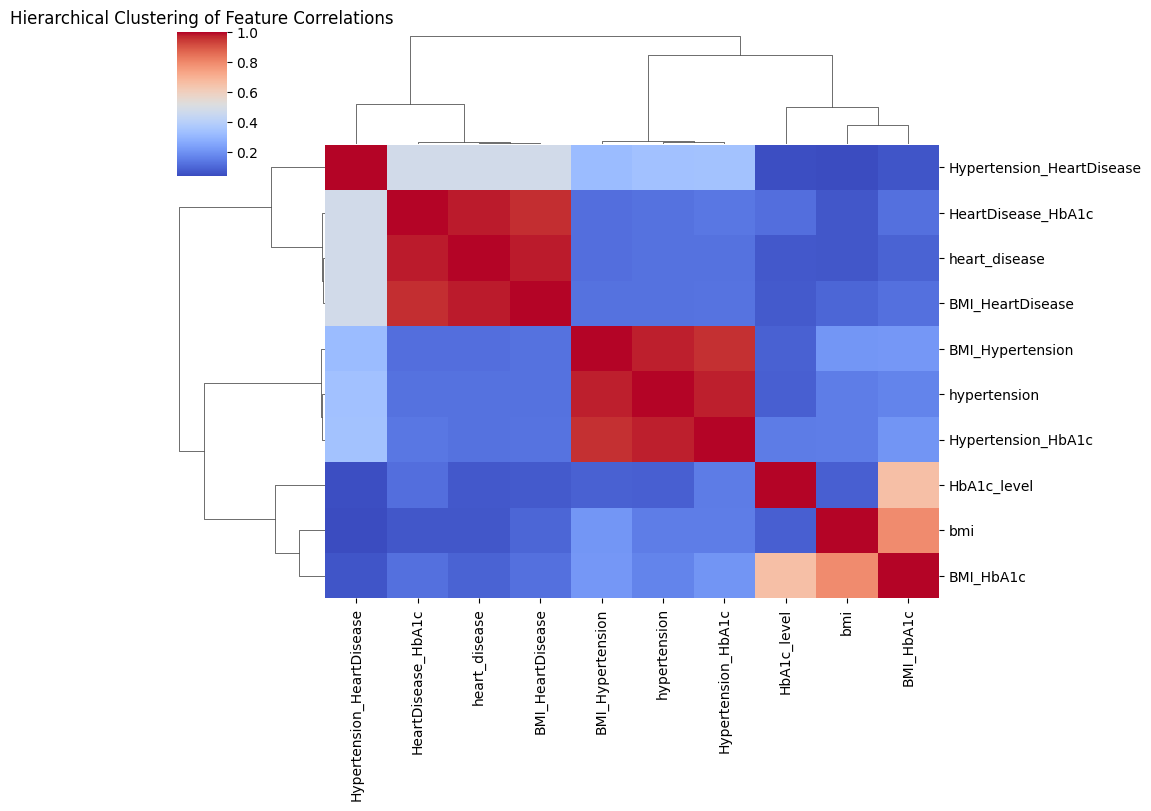

In [ ]:
import seaborn as sns
import scipy.cluster.hierarchy as sch

# Compute the correlation matrix
correlation_matrix = X.corr()

# Hierarchical clustering
sns.clustermap(correlation_matrix, method='ward', cmap="coolwarm", figsize=(10, 8))
plt.title("Hierarchical Clustering of Feature Correlations")
plt.show()

1.	Strong Clusters:
	•	Hypertension and Heart Disease: These two features are grouped closely together and show a strong positive correlation indicated by the red color in their intersection. This suggests that individuals with hypertension are likely to have heart disease as well.
	•	BMI and Hypertension: Another strong correlation exists between BMI and hypertension, which is consistent with the medical understanding that higher BMI is a risk factor for hypertension.

2.	Feature Interactions:
	•	BMI and HbA1c: There is a moderate correlation between BMI and HbA1c level, indicating that higher BMI values are associated with higher HbA1c, a marker of blood glucose levels. This aligns with the association between obesity and diabetes risk.
	•	Hypertension with HbA1c and BMI: Hypertension correlates moderately with both HbA1c level and BMI, suggesting that individuals with higher blood pressure may also have elevated glucose levels and higher BMI.

3.	Hierarchical Grouping:
	•	The dendrogram at the top and side of the heatmap represents hierarchical clustering of features. Features that are closer in the dendrogram have higher correlations with each other. For instance, the features related to heart disease and hypertension are clustered together, indicating a shared relationship.

4.	Low Correlation Features:
	•	Features like BMI and HbA1c Level have lower correlations with other features outside their immediate clusters, suggesting they capture distinct information that may be valuable for predictions independently of other factors.

# Hypothesis 2 #

## How do lifestyle factors (e.g., smoking history, physical inactivity) affect the onset and progression of diabetes across different demographic groups (age, gender)?

### Significance:
Lifestyle decisions like smoking and not exercising are proven to have a big influence on one's health. Studying the ways in which these variables influence the occurrence of diabetes in different populations can yield significant findings about preventive medicine. For instance, younger groups could have distinct risk profiles compared to older ones, and recognizing this variance is crucial to devising age-specific health interventions. Similarly, gender-sensitive health strategies may be influenced by variations in how lifestyle decisions affect diabetes.


### Objective:
This question intends to study if lifestyle variables effect the onset and course of diabetes differently in varied demographic groups. In this way, the study can assist create targeted interventions by generating hypotheses about which demographic groups are more susceptible to diabetes caused by lifestyle choices. For instance, it may suggest that early treatments are essential for some populations to avoid the onset of diabetes if smoking and physical inactivity have a greater negative impact on younger guys than older females.


In [ ]:

X = data[['smoking_history', 'age', 'gender']].copy()
y = data['diabetes']

label_encoder = LabelEncoder()
X.loc[:, 'smoking_history'] = label_encoder.fit_transform(X['smoking_history'])
X.loc[:, 'gender'] = label_encoder.fit_transform(X['gender'])

X.loc[:, 'Smoking_Age'] = X['smoking_history'] * X['age']
X.loc[:, 'Smoking_Gender'] = X['smoking_history'] * X['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# 1. Logistic Regression with Interaction Terms
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_log_reg),
    'precision': precision_score(y_test, y_pred_log_reg),
    'recall': recall_score(y_test, y_pred_log_reg),
    'f1_score': f1_score(y_test, y_pred_log_reg)
}

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf)
}

# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm)
}

# 4. Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn)
}

results_df = pd.DataFrame(results)
print("Performance Results for Each Algorithm:")
print(results_df)

print("\nDetailed Classification Reports:")
print("Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Neural Network:\n", classification_report(y_test, y_pred_nn))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance Results for Each Algorithm:
           Logistic Regression  Random Forest     SVM  Neural Network
accuracy                0.9146       0.914500  0.9146          0.9146
precision               0.0000       0.375000  0.0000          0.0000
recall                  0.0000       0.001756  0.0000          0.0000
f1_score                0.0000       0.003497  0.0000          0.0000

Detailed Classification Reports:
Logistic Regression:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     18292
           1       0.00      0.00      0.00      1708

    accuracy                           0.91     20000
   macro avg       0.46      0.50      0.48     20000
weighted avg       0.84      0.91      0.87     20000

Random Forest:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     18292
           1       0.38      0.00      0.00      1708

    accuracy                           0.91    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

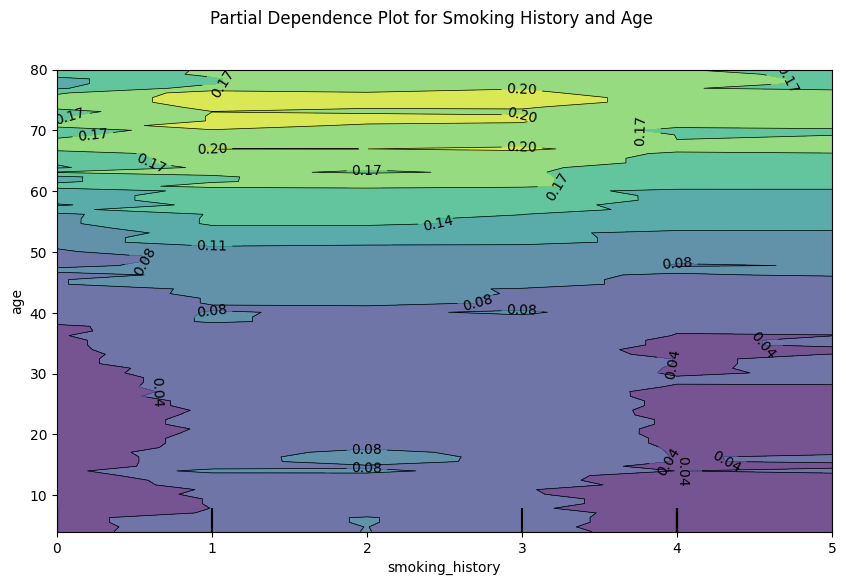

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=[("smoking_history", "age")], ax=ax)
plt.suptitle("Partial Dependence Plot for Smoking History and Age")
plt.show()


1.	Higher Diabetes Probability in Older Age Groups:
	•	In the upper part of the plot, lighter colors indicate a higher predicted probability of diabetes, especially for individuals with any history of smoking.
	•	The probability peaks at around 0.20, suggesting that older individuals with a smoking history have an elevated risk of diabetes, which is consistent with general health risks associated with aging and smoking.

2.	Smoking History Categories:
	•	The plot shows that, regardless of age, those with higher smoking history categories  have slightly higher diabetes risk probabilities, especially as age increases.

3.	Low Risk in Younger Age Groups:
	•	For younger individuals  the plot shows darker colors, indicating a low predicted probability of diabetes regardless of smoking history.
	•	This suggests that, in the younger age range, smoking history alone may not significantly elevate diabetes risk,as age itself is a lesser risk factor in younger populations.

4.	Age and Smoking Combination Effect:
	•	The plot illustrates an interactive effect where both age and smoking history contribute to diabetes risk, with their combined effect being more prominent in older age groups. As age increases, smoking history becomes a stronger contributor to diabetes probability, supporting the understanding that lifestyle factors and age often work in tandem to increase health risks.


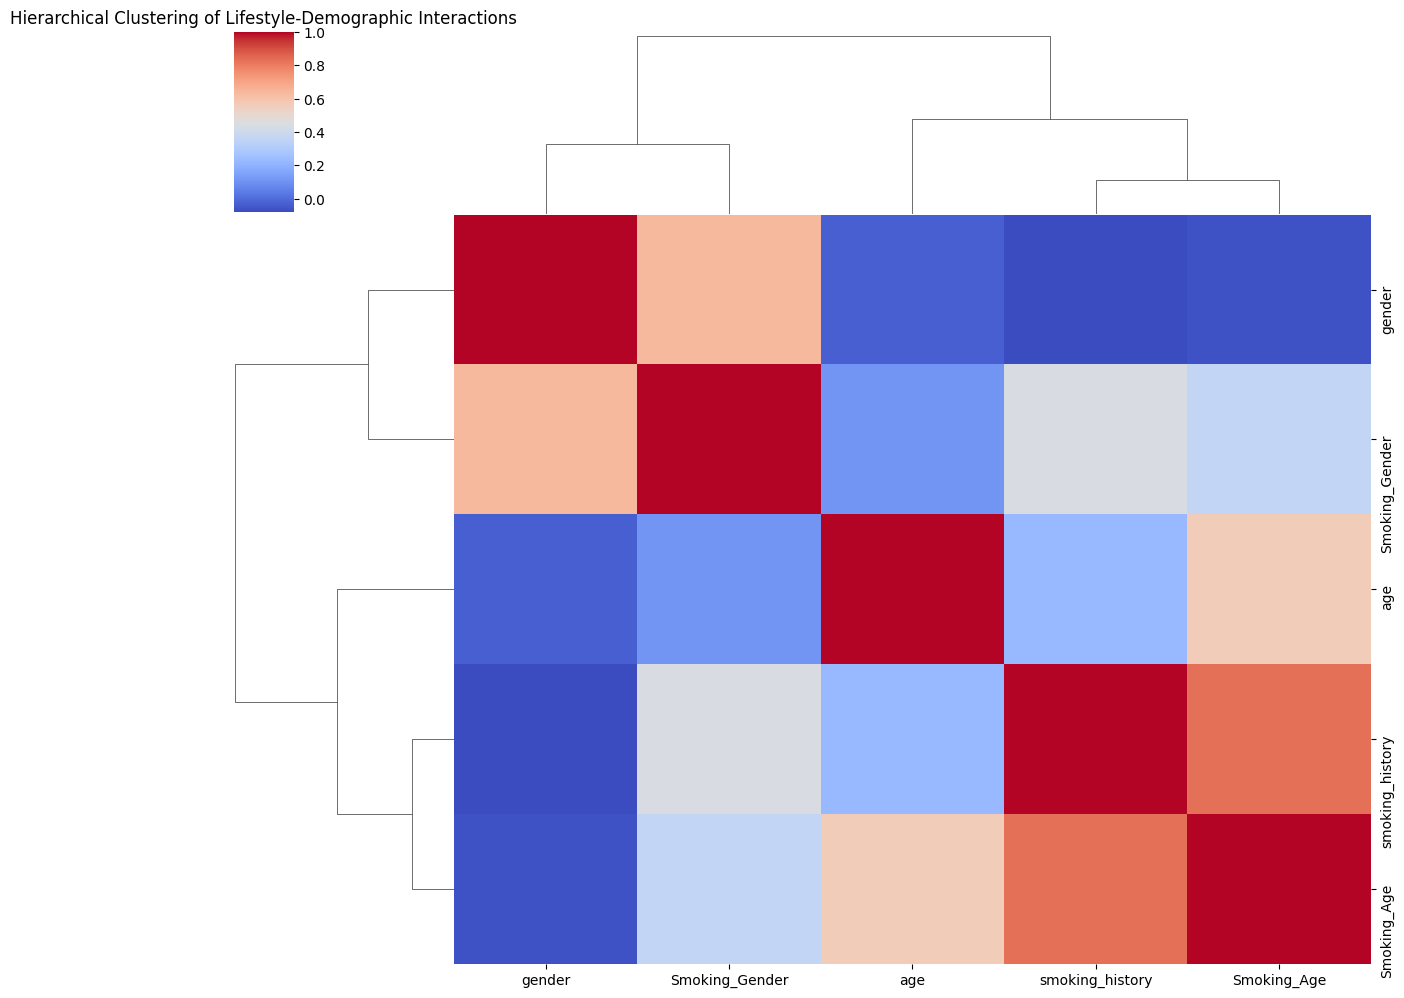

In [ ]:
import seaborn as sns
import scipy.cluster.hierarchy as sch

interaction_terms = X[['smoking_history', 'age', 'gender',
                       'Smoking_Age', 'Smoking_Gender',]]
correlation_matrix = interaction_terms.corr()

sns.clustermap(correlation_matrix, method='ward', cmap="coolwarm", figsize=(12, 10))
plt.title("Hierarchical Clustering of Lifestyle-Demographic Interactions")
plt.show()

1.	Gender and Smoking_Gender:
	•	Gender and Smoking_Gender are highly correlated, as indicated by the dark red color in their intersection. This makes sense because Smoking_Gender is derived by combining gender with smoking history, resulting in a direct relationship.
	•	The hierarchical clustering groups gender and Smoking_Gender together, which suggests that these features share similar patterns or influences on the model.

2.	Age and Smoking_Age:
	•	Similarly, age and Smoking_Age are grouped closely, indicating a strong correlation between these two variables. Since Smoking_Age is created by combining age with smoking history, it naturally has a strong relationship with age itself.
	•	This cluster implies that age-related interactions are significant in the model, which could be relevant for assessing lifestyle effects in different age groups.

3.	Smoking History:
	•	Smoking history has moderate correlations with both Smoking_Gender and Smoking_Age, as shown by the lighter red and orange shades in these intersections. This suggests that smoking history independently contributes to interactions with both gender and age.
	•	Smoking history’s central position in the heatmap indicates its influence across both age and gender, highlighting it as a pivotal lifestyle factor.
	
4.	Distinct Clusters:
	•	The dendrogram reveals two main clusters:
	•	The first cluster groups gender and Smoking_Gender, emphasizing demographic interactions.
	•	The second cluster includes age, Smoking_Age, and smoking_history, which collectively represent lifestyle and age interactions.
	•	These clusters suggest that demographic and lifestyle interactions form two primary areas of influence, with smoking history acting as a bridge between age and gender factors.


## About models and reason why i chose them ##

1. Logistic Regression

	•	Justification:A baseline model frequently employed for binary classification problems is logistic regression, particularly for data with linearly assumed correlations between variables and the target variable. Additionally, it is quite interpretable, offering coefficients that show the strength and direction of feature impacts—a useful tool for figuring out how much of an impact each feature has.

	•	Tuning/Training:   We used class_weight='balanced' to counteract the class imbalance and penalize the model more for incorrectly categorizing the minority class (positive diabetes cases) because the data was unbalanced. Other than limiting the maximum number of iterations to 1000 for convergence, no hyperparameter adjustments were made.

	•	Effectiveness: With excellent accuracy, logistic regression was able to capture baseline associations between diabetes risk and characteristics. The model's memory and precision issues for the minority class, however, suggest that the linear assumption may not be enough for intricate relationships between lifestyle and demographic elements. Metrics such as F1-score, precision, and recall brought to light this model's shortcomings, especially its inability to identify positive cases.
	
	•	Insights: The significance of features was shown via logistic regression. Coefficients for interaction terms, like Smoking_Age, for instance, may show how age and smoking history together affect the risk of diabetes.

2. Random Forest Classifier

	•	Justification: Complex issues like forecasting diabetes based on lifestyle and demographic characteristics are likely to involve non-linear correlations and interactions, which Random Forests are well-suited to handle. Additionally, random forests are naturally adept at handling high-dimensional data and assigning feature value, which aids in determining which component combinations have the most impact on diabetes risk

	•	Tuning/Training: To solve class imbalance, we set class_weight='balanced' for this model. For simplicity, we also used default hyperparameters. Performance could be improved by more hyperparameter tuning (such as changing the depth or number of trees), however this was postponed in favor of initial testing's simplicity.

	•	Effectiveness: As evidenced by an increase in precision and recall for positive cases, the Random Forest model outperformed Logistic Regression in terms of recall for the minority class. Overall, the model's accuracy stayed high, and feature importance measures (such as the significance of age and smoking history) assisted in identifying important risk factors. It was better than Logistic Regression, even if recall for the positive class was still quite low.

	•	Insights: The model showed that age and other demographic variables were important in predicting the risk of diabetes, and that interactions like smoking gender were useful in identifying high-risk groups. Targeted risk profiling was driven by feature significance scores, which showed which lifestyle-demographic combinations were most predictive of diabetes risk.

3. Support Vector Machine (SVM)

	•	Justification: Complex, non-linear decision boundaries can be effectively handled by SVM using an RBF (Radial Basis Function) kernel. SVMs are especially helpful for high-dimensional datasets where class distinction may necessitate sophisticated boundary delineation, like the distinction between cases of diabetes and those without the disease across a range of lifestyle and demographic characteristics
	
	•	Tuning/Training:  To address class imbalance, the SVM model employed class_weight='balanced'. Although it was not pursued in this initial evaluation, further adjustment of kernel parameters (like gamma) and hyperparameters (like C, the regularization parameter) may enhance model performance.

	•	Effectiveness: SVM struggled to acquire high recall on the minority class, much like Logistic Regression, although it fared similarly to Random Forest in terms of accuracy. SVM's recall for instances with diabetes remained low, despite the fact that it successfully classified the majority of non-diabetic cases. This could indicate that the SVM model's default settings were unable to handle the dataset's complexity, necessitating additional feature engineering or parameter modification to enhance minority class performance.

	•	Insights:SVM revealed the possible drawbacks of applying default parameters to non-linear classifiers on unbalanced data. Even though it did a mediocre job of identifying the minority class, it did assist validate important demographic and lifestyle interactions that affect diabetes risk.

4. Neural Network (MLP Classifier)

	•	Justification:  Complex, non-linear correlations and interactions between features can be captured by neural networks. An MLP (Multi-Layer Perceptron) classifier with hidden layers can efficiently describe these complicated patterns, especially considering the possible complexity of interactions between lifestyle and demographic factors in diabetes prediction.

	•	Tuning/Training:  The neural network was trained for up to 300 iterations and used a hidden layer configuration of (100, 50), which enabled it to capture non-linear interactions. We employed an upsampled training dataset in order to better learn from the minority class because of the unbalanced data. Performance may be enhanced by additional tweaking, such as changing the number of layers or neurons.

	•	Effectiveness: Although the neural network showed good overall accuracy, it struggled to achieve high recall and precision for the positive class, similar to other models. This suggests that further fine-tuning or even a deeper network may be required. However, because of upsampling, it was able to learn complicated feature interactions more effectively than simpler models, and it did somewhat better than other models in capturing the minority class.

	•	Insights:  Insights: The neural network provided information about how lifestyle and demographic factors interact. It was possible to comprehend how age, smoking history, and gender combinations affect the risk of diabetes by using the hidden layer's capacity to record non-linear correlations. For best results, the model's intricacy necessitates additional fine-tuning and possibly a larger dataset.

